# Restaurants Recommendation BOT

#### Author : Badari Prasad H

## Part 1: Project Background

In today's digital age, recommendation and comparision has become the go-to option for many consumers. However, the overwhelming number of choices and the lack of personalized assistance can make the shopping experience daunting. To address this, we have developed **Restaurants recommendation AI, a chatbot that combines the power of large language models and rule-based functions to ensure accurate and reliable information delivery**.



## Problem Statement:

##### Given a dataset containing information about restaurants (Cuisine Variety, Ambiance, Rating, Alcohol Served, Smoking Permitted, Price Range), build a chatbot that parses the dataset and provides accurate restaurant recommendations based on user requirements.

In [1]:
# Install OpenAI library
!pip install -U -q openai tenacity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00


## Import the libraries

In [2]:
# Import the libraries
import pandas as pd
import os, json, ast
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

from IPython.display import display, HTML
# Set the display width to control the output width
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Loading the OpenAI API key

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# Read the OpenAI API key
openai.api_key = open("/content/gdrive/MyDrive/Upgrad/GenAI/GenAIText.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

Mounted at /content/gdrive


### Dataset

We have a set of files downloaded from :
https://www.kaggle.com/datasets/uciml/restaurant-data-with-consumer-ratings

The set of files that we will be using are as follows:
Restaurants
* chefmozaccepts.csv
* chefmozcuisine.csv
* chefmozhours4.csv
* chefmozparking.csv
* geoplaces2.csv

The files are saved in a folder named as data

#### Loading the data from files in individual DataFrames


In [4]:
df1 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/chefmozaccepts.csv', index_col=0)
df2 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/chefmozcuisine.csv', index_col=0)
df3 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/chefmozhours4.csv', index_col=0)
df4 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/chefmozparking.csv', index_col=0)
df5 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/geoplaces2.csv', index_col=0)
df6 = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/rating_final.csv', index_col=0)


#### Merge DataFrames based on the common column 'placeID'


In [5]:
merged_df1 = pd.merge(df1, df2, on='placeID', how='inner')
merged_df2 = pd.merge(df3, df4, on='placeID', how='inner')
merged_df3 = pd.merge(df5, df6, on='placeID', how='inner')
merged_df4 = pd.merge(merged_df1, merged_df2, on='placeID', how='inner')
merged_df5 = pd.merge(merged_df3, merged_df4, on='placeID', how='inner')


#### Checking the shape

In [6]:
merged_df5.shape

(6276, 29)

#### Adding a function to get a url link

In [7]:
def generate_google_map_link(latitude, longitude):
    # print(latitude, longitude)
    base_url = "https://www.google.com/maps/search/?api=1&query="
    return base_url + str(latitude) + "," + str(longitude)

merged_df5['gps_link'] = merged_df5.apply(lambda row: generate_google_map_link(row['latitude'], row['longitude']), axis=1)


### Removing rows with duplicate restaurant names

In [8]:
# merged_df5.drop_duplicates(subset='name', inplace=True)
merged_df5.isnull().sum()

placeID           0
latitude          0
longitude         0
the_geom_meter    0
name              0
address           0
city              0
state             0
country           0
fax               0
zip               0
alcohol           0
smoking_area      0
dress_code        0
accessibility     0
price             0
url               0
Rambience         0
franchise         0
area              0
other_services    0
rating            0
food_rating       0
service_rating    0
Rpayment          0
Rcuisine          0
hours             0
days              0
parking_lot       0
gps_link          0
dtype: int64

In [9]:
merged_df5.shape

(6276, 30)

### Removing unneccessary columns

In [10]:
merged_df5.drop(columns=['the_geom_meter'], inplace=True)
merged_df5.drop(columns=['fax','placeID'], inplace=True)
merged_df5.drop(columns=['url','parking_lot'], inplace=True)
merged_df5.drop(columns=['latitude','longitude'], inplace=True)
merged_df5.drop(columns=['franchise','zip', 'dress_code', 'food_rating','service_rating'], inplace=True)
# merged_df5.drop(columns=['accessibility','Rambience','userID','Rpayment', 'other_services'], inplace=True)
merged_df5.drop(columns=['accessibility','Rpayment', 'other_services'], inplace=True)



In [11]:
merged_df5.shape

(6276, 15)

### Merge Address related columns into one columns.
Then delete the unnecessary columns

In [12]:
merged_df5['address'] = merged_df5['address'] + ', ' + merged_df5['city'] + ', ' + merged_df5['state'] + ', ' + merged_df5['country']
merged_df5.drop(columns=['city', 'state', 'country'], inplace=True)


### Renaming few columns

In [13]:
merged_df5.rename(columns={'rating': 'Rating'}, inplace=True)
merged_df5.rename(columns={'Rcuisine': 'Cuisine Variety'}, inplace=True)
merged_df5.rename(columns={'price': 'Price Range'}, inplace=True)
merged_df5.rename(columns={'Rambience': 'Ambiance'}, inplace=True)
merged_df5.rename(columns={'smoking_area': 'Smoking Permitted'}, inplace=True)
merged_df5.rename(columns={'alcohol': 'Alcohol Served'}, inplace=True)
merged_df5.rename(columns={'name': 'Name'}, inplace=True)
merged_df5.rename(columns={'address': 'Address'}, inplace=True)
merged_df5.rename(columns={'hours': 'Operating Hours'}, inplace=True)
merged_df5.rename(columns={'days': 'Days'}, inplace=True)
merged_df5.rename(columns={'area': 'Area'}, inplace=True)

### Search replace few values

In [14]:
merged_df5['Rating'].replace(2, "high", inplace=True)
merged_df5['Rating'].replace(1, "medium", inplace=True)
merged_df5['Rating'].replace(0, "low", inplace=True)

merged_df5['Address'].replace('?, ?, ?, ?', "tamaulipas", inplace=True)
merged_df5['Address'].replace('?,', "tamaulipas", inplace=True)

merged_df5['Smoking Permitted'].replace('none', 'no', inplace=True)
merged_df5['Smoking Permitted'].replace('not permitted', 'no', inplace=True)
merged_df5['Smoking Permitted'].replace('section', 'yes', inplace=True)
merged_df5['Smoking Permitted'].replace('permitted', 'yes', inplace=True)
merged_df5['Smoking Permitted'].replace('only at bar', 'yes', inplace=True)


merged_df5['Alcohol Served'].replace('No_Alcohol_Served', 'no', inplace=True)
merged_df5['Alcohol Served'].replace('Wine-Beer', 'yes', inplace=True)
merged_df5['Alcohol Served'].replace('Full_Bar', 'yes', inplace=True)

<ipython-input-14-136844d9cfa4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df5['Rating'].replace(2, "high", inplace=True)
<ipython-input-14-136844d9cfa4>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [15]:
merged_df5['Cuisine Variety'].value_counts()

Cuisine Variety
Mexican             1278
Bar                  843
Cafeteria            546
Bar_Pub_Brewery      489
Fast_Food            471
Pizzeria             423
International        339
Contemporary         288
Japanese             285
Seafood              246
Burgers              225
American             213
Chinese              174
Italian              126
Breakfast-Brunch     108
Family                72
Vietnamese            54
Cafe-Coffee_Shop      36
Game                  21
Bakery                15
Armenian              12
Regional              12
Name: count, dtype: int64

## Current count of dataframe is 6276, which takes a lot of time in processing. Hence reducing size to 100

In [16]:


import random
current_length = len(merged_df5)
print("Current dataset length:", current_length)

# Define the target length (500 in this case)
target_length = 100

# Calculate the number of rows to delete
rows_to_delete = current_length - target_length

# Randomly select rows to delete
rows_to_delete_indices = random.sample(range(current_length), rows_to_delete)

# Delete selected rows
merged_df5 = merged_df5.drop(rows_to_delete_indices)


Current dataset length: 6276


In [17]:
merged_df5.shape

(100, 12)

### Displaying the Cuisine Variety

In [18]:
merged_df5['Cuisine Variety'].value_counts()

Cuisine Variety
Mexican             20
Bar_Pub_Brewery     12
Contemporary        12
Cafeteria           10
Pizzeria             7
Fast_Food            6
International        6
Chinese              5
Japanese             4
Bar                  4
Seafood              4
Burgers              3
American             3
Family               2
Breakfast-Brunch     2
Name: count, dtype: int64

Limiting the Cuisine Variety to following by search replacing:
* Mexican   
* Bar       
* Cafeteria

In [19]:
merged_df5.head(2)

Name                                            Address Alcohol Served  \
80  puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
85  puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   

   Smoking Permitted Price Range  Ambiance  Area  Rating Cuisine Variety Operating Hours  Days  \
80                no         low  familiar  open  medium         Mexican    09:00-12:00;  Sun;   
85                no         low  familiar  open     low         Mexican    09:00-12:00;  Sat;   

                                             gps_link  
80  https://www.google.com/maps/search/?api=1&quer...  
85  https://www.google.com/maps/search/?api=1&quer...

### Saving the merged data into a csv file

In [20]:
merged_df5.to_csv("/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/merged_df.csv")

In [21]:
merged_df5.Ambiance.value_counts()

Ambiance
familiar    95
quiet        5
Name: count, dtype: int64

### Now loading the file into a new dataframe

In [22]:
df = pd.read_csv("/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/merged_df.csv", index_col=0)
df.head(3)

Name                                            Address Alcohol Served  \
80              puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
85              puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
163  El Rinc�n de San Francisco  Universidad 169, San Luis Potosi, San Luis Pot...            yes   

    Smoking Permitted Price Range  Ambiance  Area  Rating Cuisine Variety Operating Hours  Days  \
80                 no         low  familiar  open  medium         Mexican    09:00-12:00;  Sun;   
85                 no         low  familiar  open     low         Mexican    09:00-12:00;  Sat;   
163               yes      medium  familiar  open     low         Mexican    18:00-23:30;  Sat;   

                                              gps_link  
80   https://www.google.com/maps/search/?api=1&quer...  
85   https://www.google.com/maps/search/?api=1&quer...  
163  https://www.google.com/maps/search/?api=1&quer...

#### Approach:

1. **Conversation and Information Gathering**: The chatbot will utilize language models to understand and generate natural responses. Through a conversational flow, it will ask relevant questions to gather information about the user's requirements.
2. **Information Extraction**: Once the essential information is collected, rule-based functions come into play, extracting top 3 laptops that best matches the user's needs.
3. **Personalized Recommendation**: Leveraging this extracted information, the chatbot engages in further dialogue with the user, efficiently addressing their queries and aiding them in finding the perfect laptop solution.

## Part2 : System Design

Now we have dataset where each row describes the features of a restaurant and also has a google map link at the end. The chatbot that we build will leverage LLMs to parse this data and provide gps_link along with recommendations

#### Workings of the Chatbot

**Note** - As you could see in the output above, the chatbot should ask a series of questions to
- Determine the user's requirments. For simplicity, we have used 6 features to encapsulate the user's needs.
- The 6 features (in a Python dictionary) are as follows :
    - Cuisine Variety,
    - Ambiance,
    - Area,
    - Rating,
    - Alcohol Served,
    - Smoking Permitted, and
    - Price Range

- Confirm if the user's requirements have been correctly captured at the end.

After that the chatbot lists down the top 3 recomandations that are the most relevant, and engages in further conversation to help the user find the best one.

#### Building the Chatbot

Now let's go ahead and understand the system design for the chatbot.

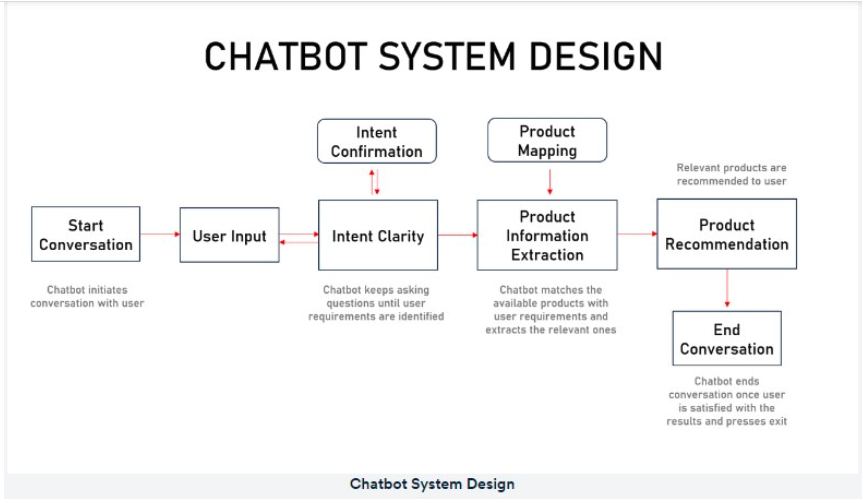

In [23]:
from IPython.display import Image
# display(Image(url="/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/chatbot.png", width=900, height=900))
iamge_path = "/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/chatbot.png"
display(Image(filename=iamge_path, width=900, height=900))


|`Stage 1`

- Intent Clarity Layer
- Intent Confirmation Layer

`Stage 2`

- Product Mapping Layer
- Product Information Extraction Layer

`Stage 3`

- Product Recommendation Layer

##### Major functions behind the Chatbot

Let's now look at a brief overview of the major functions that form the chatbot. We'll take a deep dive later



- `initialize_conversation()`: This initializes the variable conversation with the system message.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant
- `moderation_check()`: This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, it ends the conversation.
- `intent_confirmation_layer()`: This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not GPU intensity, Display quality, Portability, Multitasking, Processing speed, Budget
- `dictionary_present()`: This function checks if the final understanding of user's profile is returned by the chatbot as a python dictionary or not. If there is a dictionary, it extracts the information as a Python dictionary.
- `compare_laptops_with_user()`: This function compares the user's profile with the different laptops and come back with the top 3 recommendations.
- `initialize_conv_reco()`: Initializes the recommendations conversation

In the next sections, we will look at how to write the code for the above functions.

## Part 3: Implementation

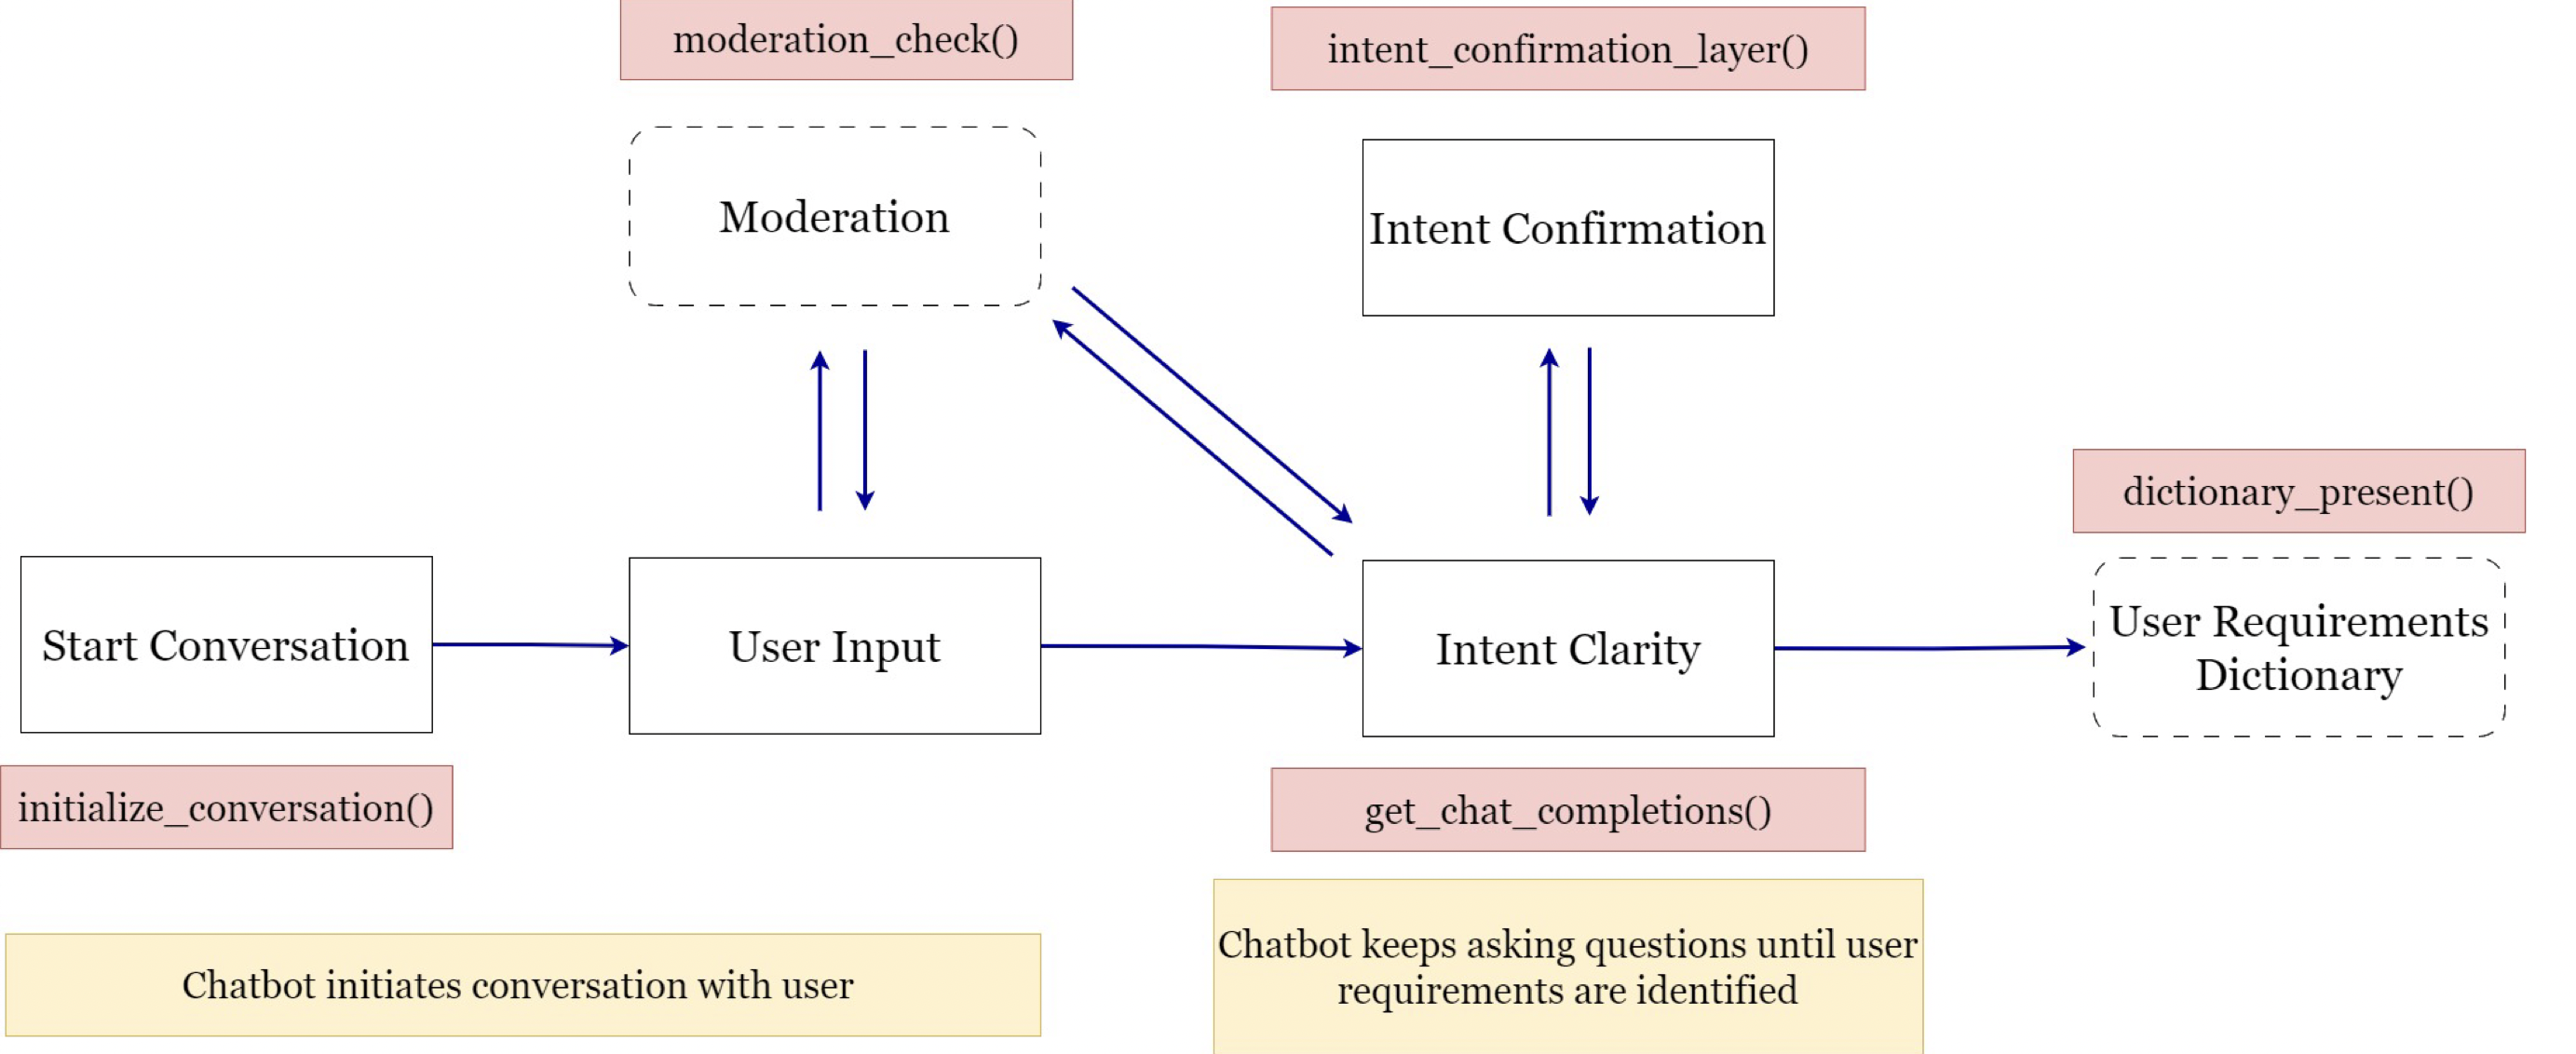

In [24]:
from IPython.display import Image
# Image(url="/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/stage1.png", width=1000, height=800)
iamge_path = "/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/stage1.png"
display(Image(filename=iamge_path, width=1000, height=800))

### 3.2 - Implementing Intent Clarity and Intent Confirmation Layers

Let's start with the first part of the implementation - building the `intent clarity` and `intent confirmation` layers. As mentioned earlier, this layer helps in identifying the user requirements and passing it on to the product matching layer. Here are the functions that we would be using for building these layers:

- `initialize_conversation()`


### `initialize_conversation()`:
This initializes the variable conversation with the system message. Using prompt engineering and chain of thought reasoning, the function will enable the chatbot to keep asking questions until the user requirements have been captured in a dictionary. It also includes Few Shot Prompting(sample conversation between the user and assistant) to align the model about user and assistant responses at each step.



```
def initialize_conversation():
    '''
    Initializes a conversation for an intelligent restaurant gadget expert system.

    Returns:
        list: [{"role": "system", "content": system_message}]
        A list containing a dictionary representing the system's initial message.
        
    The function initializes a conversation with the user, providing instructions, examples,
    and a sample conversation to guide the user in interacting with the system. The system's
    initial message includes information about the purpose of the conversation, instructions
    for filling in user profile details, guidelines for asking questions, and a sample
    conversation demonstrating how the interaction with the system progresses.

    The system expects the user to provide information related to their restaurant requirements,
    including :
    - Cuisine Variety,
    - Ambiance,
    - Area,
    - Rating,
    - Alcohol Served,
    - Smoking Permitted,
    - Price Range
    The provided information is used to update a predefined dictionary
    representing the user's profile. The system emphasizes extracting specific details from
    the user's responses to accurately fill in the dictionary values.

    The conversation flow involves three main thoughts:
    - Thought 1: Understanding the user's profile and filling confident values.
    - Thought 2: Filling values for remaining keys based on gathered information.
    - Thought 3: Confirming and verifying updated dictionary values.

    Users are encouraged to engage in a meaningful conversation with the system to ensure
    accurate profile representation and tailored recommendations for the best restaurant choice.

    Usage:
        # Initialise the conversation
        conversation = initialize_conversation()
        # Print the conversation
        print(conversation)
    '''
    ```



In [25]:
def initialize_conversation():
    '''
    Returns a list [{"role": "system", "content": system_message}]
    '''

    delimiter = "####"

    example_user_dict = {
        'Cuisine Variety': "Mexican",
         'Area': "closed",
         'Ambiance': "quiet",
         'Rating': "low",
         'Alcohol Served': "no",
         'Smoking Permitted': "no",
         'Price Range': "low"
    }

    example_user_req = {
        'Cuisine Variety': "_",
        'Ambiance': "_",
        'Area': "_",
        'Rating': "_",
        'Alcohol Served': "_",
        'Smoking Permitted': "_",
        'Price Range': "_"
    }

    system_message = f"""
    Welcome to our Restaurant Recommendation Chatbot!

    Your goal is to assist user in finding the perfect restaurant based on their preferences and requirements.

    You need to ask relevant questions and understand the user's dining preferences by analyzing their responses.

    Your final objective is to fill in the values for different features listed below:
        - Cuisine Variety,
        - Ambiance,
        - Area,
        - Rating,
        - Alcohol Served,
        - Smoking Permitted, and
        - Price Range in a Python dictionary

    After filling the keys, be confident of the requirements. If there is confusion, then give reason very very clearly.

    These key-value pairs define the user's dining profile.
    The Python dictionary looks like this:

    {{'Cuisine_Variety': 'values', 'Area': 'values', 'Ambiance': 'values', 'Rating': 'values', 'Alcohol_Served': 'values', 'Smoking_Permitted': 'values', 'Price_Range': 'values'}}

    The values for 'Price Range' should be 'low', 'medium', or 'high' based on the user's budget preferences.
    All the values in the example dictionary are only representative values.

    Here are some instructions around the values for the different keys. If you do not follow this, you'll be heavily penalized:
    - The values for all keys, except 'Price_Range', should strictly be either 'low', 'medium', or 'high' based on the importance of the corresponding features, as stated by the user.
    - The value for 'Price_Range' should be a category determined by the user's budget preferences.
    - Do not randomly assign values to any of the keys.
    - The values need to be inferred from the user's responses.

    To fill the dictionary, you need to have the following chain of thoughts:

    Follow the chain-of-thoughts below and only output the final updated Python dictionary for the keys as described in the example user requirements.

    Thought 1: Ask questions to understand the user's dining preferences and requirements.
    Identify the keys for which you can fill the values confidently using the understanding.
    If the necessary information has been extracted, proceed to the next step. Otherwise, rephrase the question to capture their preferences clearly.

    Thought 2: Now, you are trying to fill the values for the rest of the keys which you couldn't in the previous step.
    Ask questions you might have for all the keys to strengthen your understanding of the user's dining preferences.
    If necessary, move to the next step. If not, ask questions on the keys whose values you are unsure of.

    Thought 3: Check if you have correctly updated the values for the different keys in the Python dictionary.
    If you are not confident about any of the values, ask clarifying questions.

    Here is a sample conversation between the user and assistant:
    User: "Hi, I'm craving Maxican cuisine."

    Assistant: "Great! Maxican cuisine is known for its diverse flavors and rich history.     Do you prefer a open area or a more upscale dining experience?"
    User: "I prefer a open area."

    Assistant: "Got it! A open area can enhance your dining experience.     Do you have any specific preferences for ambiance?"
    User: "I prefer a quite ambiance."

    Assistant: "Got it! A quite ambiance can enhance your dining experience.     Do you have any specific preferences for alcohol service?"
    User: "Yes, I'd like a restaurant that serves no alcohol."

    Assistant: "Thank you for letting me know. Are you comfortable with smoking areas in the restaurant?"
    User: "No, I prefer no smoking areas."

    Assistant: "Understood. Could you kindly specify your price range for dining out?"
    User: "My budget is around low"

    Assistant: "{example_user_dict}"

    Start with a warm welcome message and encourage the user to share their dining preferences.
    """
    conversation = [{"role": "system", "content": system_message}]
    # conversation = system_message
    return conversation

debug_conversation = initialize_conversation()

### Let's initialise conversation


In [26]:
system_message = initialize_conversation()
print(system_message[0]["content"])


    Welcome to our Restaurant Recommendation Chatbot!

    Your goal is to assist user in finding the perfect restaurant based on their preferences and requirements.

    You need to ask relevant questions and understand the user's dining preferences by analyzing their responses.

    Your final objective is to fill in the values for different features listed below:
        - Cuisine Variety,
        - Ambiance,
        - Area,
        - Rating,
        - Alcohol Served,
        - Smoking Permitted, and
        - Price Range in a Python dictionary

    After filling the keys, be confident of the requirements. If there is confusion, then give reason very very clearly.

    These key-value pairs define the user's dining profile.
    The Python dictionary looks like this:

    {'Cuisine_Variety': 'values', 'Area': 'values', 'Ambiance': 'values', 'Rating': 'values', 'Alcohol_Served': 'values', 'Smoking_Permitted': 'values', 'Price_Range': 'values'}

    The values for 'Price Range' should

In [27]:
df.head()

Name                                            Address Alcohol Served  \
80              puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
85              puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
163  El Rinc�n de San Francisco  Universidad 169, San Luis Potosi, San Luis Pot...            yes   
172  El Rinc�n de San Francisco  Universidad 169, San Luis Potosi, San Luis Pot...            yes   
201               carnitas_mata  lic. Emilio portes gil, victoria, Tamaulipas, ...             no   

    Smoking Permitted Price Range  Ambiance    Area  Rating Cuisine Variety Operating Hours  \
80                 no         low  familiar    open  medium         Mexican    09:00-12:00;   
85                 no         low  familiar    open     low         Mexican    09:00-12:00;   
163               yes      medium  familiar    open     low         Mexican    18:00-23:30;   
172               yes      medium  familiar    open    high         Mexican    18:00-23:30;   
201               yes      medium  familiar  closed  medium         Mexican    08:00-16:00;   

                     Days                                           gps_link  
80                   Sun;  https://www.google.com/maps/search/?api=1&quer...  
85                   Sat;  https://www.google.com/maps/search/?api=1&quer...  
163                  Sat;  https://www.google.com/maps/search/?api=1&quer...  
172                  Sat;  https://www.google.com/maps/search/?api=1&quer...  
201  Mon;Tue;Wed;Thu;Fri;  https://www.google.com/maps/search/?api=1&quer...

### Let's now look at the next function.
- `get_chat_completions()`: This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

### `get_chat_completions()`:

This takes the ongoing conversation as the input and returns the response by the assistant. We'll use the Chat Completions function for performing LLM calls to OpenAI.

In [28]:
# Define a Chat Completions API call
# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_chat_completions(input, json_format = False):
    MODEL = 'gpt-3.5-turbo'

    system_message_json_output = """<<. Return output in JSON format to the key output.>>"""

    # If the output is required to be in JSON format
    if json_format == True:
        # Append the input prompt to include JSON response as specified by OpenAI
        input[0]['content'] += system_message_json_output

        # JSON return type specified
        chat_completion_json = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            response_format = { "type": "json_object"},
            seed = 1234)

        output = json.loads(chat_completion_json.choices[0].message.content)
        pd.DataFrame([output])

    # No JSON return type specified
    else:
        chat_completion = openai.chat.completions.create(
            model = MODEL,
            messages = input,
            seed = 2345)

        output = chat_completion.choices[0].message.content

    return output

### iterate_response() - Helper Function:
We've created a small helper test function to ensure the model's response is consistent.
Uncomment the code blocks and run the function `iterate_response(response)` to check if the response of the `intent_confirmation_layer`is consistent.}

In [29]:
def iterate_llm_response(funct, debug_response, num = 10):
    """
    Calls a specified function repeatedly and prints the results.
    This function is designed to test the consistency of a response from a given function.
    It calls the function multiple times (default is 10) and prints out the iteration count,
    the function's response(s).
    Args:
        funct (function): The function to be tested. This function should accept a single argument
                          and return the response value(s).
        debug_response (dict): The input argument to be passed to 'funct' on each call.
        num (int, optional): The number of times 'funct' will be called. Defaults to 10.
    Returns:
        This function only returns the results to the console.
    """
    i = 0  # Initialize counter

    while i < num:  # Loop to call the function 'num' times

        response = funct(debug_response)  # Call the function with the debug response

        # Print the iteration number, result, and reason from the response
        print("Iteration: {0}".format(i))
        print(response)
        print('-' * 50)  # Print a separator line for readability
        i += 1  # Increment the counter



# Example usage: test the consistency of responses from 'intent_confirmation_layer'
# iterate_llm_response(get_chat_completions, messages)

Let's pass the initialized conversation `debug_conversation` and see what is the assistant's response.

In [30]:
debug_user_input = "Hi, I am Badari. I need a Restaurant recommendation for friends dinner outing"

In [31]:
debug_conversation.append({"role": "user", "content": debug_user_input})
# print(debug_conversation[0]["content"]) # System Message
print(debug_conversation[1]["content"]) # User Input

Hi, I am Badari. I need a Restaurant recommendation for friends dinner outing


## Getting the response from the Assistant by passing the conversation to the Chat Completions API


In [32]:
debug_response_assistant = get_chat_completions(debug_conversation)
display(debug_response_assistant)

"Hello Badari! I'd be happy to help you find the perfect restaurant for your friends' dinner outing. To assist you better, could you please share some of your dining preferences and requirements? Let's start with the type of cuisine you and your friends prefer."

## Let's look at the debug_conversation list


In [33]:
# Let's append this to the conversation list
debug_conversation.append(({"role": "system", "content": debug_response_assistant}))


In [34]:
list(debug_conversation)

[{'role': 'system',
  'content': '\n    Welcome to our Restaurant Recommendation Chatbot!\n\n    Your goal is to assist user in finding the perfect restaurant based on their preferences and requirements.\n\n    You need to ask relevant questions and understand the user\'s dining preferences by analyzing their responses.\n\n    Your final objective is to fill in the values for different features listed below:\n        - Cuisine Variety,\n        - Ambiance,\n        - Area,\n        - Rating,\n        - Alcohol Served,\n        - Smoking Permitted, and\n        - Price Range in a Python dictionary\n\n    After filling the keys, be confident of the requirements. If there is confusion, then give reason very very clearly.\n\n    These key-value pairs define the user\'s dining profile.\n    The Python dictionary looks like this:\n\n    {\'Cuisine_Variety\': \'values\', \'Area\': \'values\', \'Ambiance\': \'values\', \'Rating\': \'values\', \'Alcohol_Served\': \'values\', \'Smoking_Permitted

In [35]:
display(debug_conversation[0]["content"].replace('\n    \n', '\n').replace("\n    ", "\n"))

'\nWelcome to our Restaurant Recommendation Chatbot!\n\nYour goal is to assist user in finding the perfect restaurant based on their preferences and requirements.\n\nYou need to ask relevant questions and understand the user\'s dining preferences by analyzing their responses.\n\nYour final objective is to fill in the values for different features listed below:\n    - Cuisine Variety,\n    - Ambiance,\n    - Area,\n    - Rating,\n    - Alcohol Served,\n    - Smoking Permitted, and\n    - Price Range in a Python dictionary\n\nAfter filling the keys, be confident of the requirements. If there is confusion, then give reason very very clearly.\n\nThese key-value pairs define the user\'s dining profile.\nThe Python dictionary looks like this:\n\n{\'Cuisine_Variety\': \'values\', \'Area\': \'values\', \'Ambiance\': \'values\', \'Rating\': \'values\', \'Alcohol_Served\': \'values\', \'Smoking_Permitted\': \'values\', \'Price_Range\': \'values\'}\n\nThe values for \'Price Range\' should be \'lo

### `moderation_check()`:
 This checks if the user's or the assistant's message is inappropriate. If any of these is inappropriate, you can add a break statement to end the conversation.

In [36]:
# Define a function called moderation_check that takes user_input as a parameter.

def moderation_check(user_input):
    # Call the OpenAI API to perform moderation on the user's input.
    response = openai.moderations.create(input=user_input)

    # Extract the moderation result from the API response.
    moderation_output = response.results[0].flagged
    # Check if the input was flagged by the moderation system.
    if response.results[0].flagged == True:
        # If flagged, return "Flagged"
        return "Flagged"
    else:
        # If not flagged, return "Not Flagged"
        return "Not Flagged"

### Checking the moderation_check function

In [37]:
moderation_check("I want to kill them.")

'Flagged'

In [38]:
debug_moderation = moderation_check(debug_user_input)
print(debug_moderation)

Not Flagged


In [39]:
print(moderation_check("I want to kill Ravan."))
print(moderation_check("I need a laptop"))

Flagged
Not Flagged


In [40]:
moderation_check(debug_response_assistant)

'Not Flagged'

### `intent_confirmation_layer()`:

This function takes the assistant's response and evaluates if the chatbot has captured the user's profile clearly. Specifically, this checks if the following properties for the user has been captured or not
    
    -  Cuisine Variety,
    -  Ambiance,
    -  Rating,
    -  Area,
    -  Alcohol Served,
    -  Smoking Permitted,
    -  Price Range




```
def intent_confirmation_layer(response_assistant):
    """
    This function serves as an intent confirmation layer for a laptop recommendation system using OpenAI LLM API.

    Parameters:
    - response_assistant (str): The input text containing user requirements captured through 6 keys:
    -  Cuisine Variety,
    -  Ambiance,
    -  Area,
    -  Rating,
    -  Alcohol Served,
    -  Smoking Permitted,
    -  Price Range

    Returns:
    - str: A one-word string in JSON format indicating if the values for the specified keys are correctly filled.
    - 'Yes' if the values are correctly filled for all keys ({
    'Cuisine Variety': 'value',
    'Ambiance': 'value',
    'Rating': 'value',
    'Alcohol Served': 'value',
    'Smoking Permitted': 'value',
    'Price Range': 'value'
    }) based on the importance as stated by the user.
    - 'No' otherwise.

    Note:
    - The values for all keys, except 'Price', should be 'low', 'medium', or 'high' based on their importance as stated by the user.
    - The input text should be structured such that it contains the necessary keys and their corresponding values.
    - The function uses OpenAI's Chat Completion API to evaluate the correctness of the input values.
    """
```




In [41]:
def intent_confirmation_layer(response_assistant):

    delimiter = "####"

    rating_values = {'low','medium','high'}
    area_values = {'closed', 'open'}
    ambiance_values = {'familiar', 'quite'}
    cuisine_values = {'Mexican', 'Bar', 'Cafeteria', 'Fast_Food', 'Bar_Pub_Brewery', 'International', 'Pizzeria', 'Contemporary', 'American', 'Seafood' ,'Burgers', 'Japanese', 'Chinese','Family', 'Italian','Breakfast-Brunch', 'Vietnamese','Bakery','Game','Cafe-Coffee_Shop', 'Regional'}
    price_values = {'low','medium','high'}
    alcohol_values = {'no', 'yes'}
    smoking_values = {'no', 'yes'}


    prompt = f"""
    You are a senior evaluator who has an eye for detail.The input text will contain a user requirement captured through 6 keys.
    You are provided an input. You need to evaluate if the input text has the following keys:
    {{
    'Cuisine Variety': 'value',
    'Ambiance': 'value',
    'Area': 'value',
    'Rating': 'value',
    'Alcohol Served': 'value',
    'Smoking Permitted': 'value',
    'Price Range': 'value'
    }}

    The values for the key 'Cuisine Variety' should only be from the allowed values: {cuisine_values}
    The values for the key 'Ambiance' should only be from the allowed values: {ambiance_values}
    The values for the key 'Area' should only be from the allowed values: {area_values}
    The values for the key 'Rating' should only be from the allowed values: {rating_values}
    The values for the key 'Alcohol Served' should only be from the allowed values:  {alcohol_values}
    The values for the key 'Smoking Permitted' should only be from the allowed values: {smoking_values}
    The values for the key 'Price Range' should only be from the allowed values: {price_values}



    The 'Price Range' key can take value like low/medium/high.
    Next you need to evaluate if the keys have the the values filled correctly.

    Only output a one-word string in JSON format at the key 'result' - Yes/No.
    Thought 1 - Output a string 'Yes' if the values are correctly filled for all keys, otherwise output 'No' along with the reason.
    Thought 2 - If the answer is No, mention the reason in the key 'reason'.
    THought 3 - If the reason is Missing keys and values, then give the key name.
    Thought 4 - Think carefully before the answering. Else you will be peanalized.
    """

    messages=[{"role": "system", "content":prompt },
              {"role": "user", "content":f"""Here is the input: {response_assistant}""" }]

    response = openai.chat.completions.create(
                                    model="gpt-3.5-turbo",
                                    messages = messages,
                                    response_format={ "type": "json_object" },
                                    seed = 1234
                                    # n = 5
                                    )

    json_output = json.loads(response.choices[0].message.content)

    return json_output

### Let's apply the function to the assistant's reponse and see if it has captured the user profile.

In [42]:
debug_response_assistant

"Hello Badari! I'd be happy to help you find the perfect restaurant for your friends' dinner outing. To assist you better, could you please share some of your dining preferences and requirements? Let's start with the type of cuisine you and your friends prefer."

In [43]:
debug_confirmation = intent_confirmation_layer(debug_response_assistant)
display(debug_confirmation)

{'result': 'No', 'reason': 'Missing keys and values - Cuisine Variety'}

In [44]:
# Printing the value for better clarity
print("Result:",debug_confirmation.get('result'),"\t", "Reason:", debug_confirmation.get('reason'))

Result: No 	 Reason: Missing keys and values - Cuisine Variety


#### Now, you can keep adding user and assistant responses to debug_conversation and get to a point where intent_confirmation_layer() gives yes as a response. Let's see if the following response by the assistant passes the intent_confirmation_layer() test.

In [45]:
#Let's add the above assistant response to the debug_conversation.
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})

In [46]:
# Example 1 - Let's check with the confirmation_layer if all the keys are present
debug_response_assistant_1 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{
    'Cuisine Variety': "Cafeteria",
    'Ambiance': "familiar",
    'Area': "open",
    'Rating': "low",
    'Alcohol Served': "no",
    'Smoking Permitted': "no",
    'Price Range': "medium"
}}
"""
#Note that you are using double curly braces

print(debug_response_assistant_1)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{
    'Cuisine Variety': "Cafeteria",
    'Ambiance': "familiar",
    'Area': "open",
    'Rating': "low",
    'Alcohol Served': "no",
    'Smoking Permitted': "no",
    'Price Range': "medium"
}



Do you think it'll pass the `intent_confirmation_layer()` test?

Let's try it out.

In [47]:
response = intent_confirmation_layer(debug_response_assistant_1)
response.get('result') # Extract the result key from the dictionary

'Yes'

In [48]:
# Example 2 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_2 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{
    'Cuisine Variety': "Cafeteria",
     'Ambiance': "quite",
     'Area': "open",
     'Rating': "medium",
     'Alcohol Served': "no",
     'Smoking Permitted': "no",
     'Price Range': "low"
 }}
"""
#Note that you are using double curly braces

print(debug_response_assistant_2)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{
    'Cuisine Variety': "Cafeteria",
     'Ambiance': "quite",
     'Area': "open",
     'Rating': "medium",
     'Alcohol Served': "no",
     'Smoking Permitted': "no",
     'Price Range': "low"
 }



In [49]:
intent_confirmation_layer(debug_response_assistant_2)
# iterate_llm_response(intent_confirmation_layer, debug_response_assistant_2)

{'result': 'Yes'}

In [50]:
# Example 3 - Let's check confirmation_layer if all the keys are present
debug_response_assistant_3 = f"""
Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{{
    'Cuisine Variety': "Cafeteria",
    'Ambiance': "quite",
    'Area': "closed",
    'Rating': "low",
    'Alcohol Served': "no",
    'Smoking Permitted': "yes",
    'Price Range': "medium"
    }}
"""
#Note that you are using double curly braces

print(debug_response_assistant_3)


Great, thank you for clarifying your requirements.
Based on your inputs, here is the final profile for the laptop you are looking for:
{
    'Cuisine Variety': "Cafeteria",
    'Ambiance': "quite",
    'Area': "closed",
    'Rating': "low",
    'Alcohol Served': "no",
    'Smoking Permitted': "yes",
    'Price Range': "medium"
    }



In [51]:
intent_confirmation_layer(debug_response_assistant_3)



{'result': 'Yes'}

### Let's now look at the working of `dictionary_present()`.

### `dictionary_present()`:

This function checks if the final understanding of user's profile is returned by the chatbot is a Python dictionary or not. This is important as it'll be used later on for finding the right laptops using dictionary matching.

In [52]:
def dictionary_present(response):
    delimiter = "####"

    user_req = {
                    'Cuisine Variety': "Mexican",
                    'Ambiance': "quite",
                    'Area': "open",
                    'Rating': "low",
                    'Alcohol Served': "no",
                    'Smoking Permitted': "no",
                    'Price Range': "high"
                }

    prompt = f"""You are a python expert. You are provided an input.
            You have to check if there is a python dictionary present in the string.
            It will have the following format {user_req}.
            Your task is to just extract the relevant values from the input and return only the python dictionary in JSON format.
            The output should match the format as {user_req}.

            {delimiter}
            Make sure that the value of budget is also present in the user input. ###
            The output should contain the exact keys and values as present in the input.
            Ensure the keys and values are in the given format:
            {{

             'Cuisine Variety': "Mexican/Bar/Cafeteria",
             'Ambiance': "quite/familiar",
             'Area': "open/closed",
             'Rating': "high/medium/low",
             'Alcohol Served': "no/yes",
             'Smoking Permitted': "no/yes",
             'Price Range': "high/medium/low"
            }}
            Here are some sample input output pairs for better understanding:
            {delimiter}
            input 1:
            - Cuisine Variety: 'Mexican'
            - Ambiance: quite
            - Area : open
            - Rating: "high"
            - Alcohol Served: yes
            - Smoking Permitted: medium
            - Price Range: low
            output 1: {{'Cuisine Variety': 'Mexican', 'Area': 'closed', 'Ambiance': 'quite', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'medium', 'Price Range': 'low'}}

            input 2: {{'Cuisine Variety':     'Bar', 'Area': 'closed', 'Ambiance':     'familiar', 'Rating':    'medium', 'Alcohol Served': 'yes', 'Smoking Permitted': 'yes', 'Price Range': 'medium'}}
            output 2: {{'Cuisine Variety': 'Bar', 'Ambiance': 'familiar', 'Rating': 'medium', 'Alcohol Served': 'yes', 'Smoking Permitted': 'yes', 'Price Range': 'medium'}}

            input 3: Here is your user profile 'Cuisine Variety': 'Cafeteria','Area': 'closed', 'Ambiance': 'quite','Rating': 'low','Alcohol Served': 'yes','Smoking Permitted': 'yes','Price Range': 'high'
            output 3: {{'Cuisine Variety': 'Cafeteria','Ambiance': 'open','Rating': 'low','Alcohol Served': 'yes','Smoking Permitted': 'yes','Price Range': 'high'}}
            {delimiter}
            """
    messages = [{"role": "system", "content":prompt },
                {"role": "user", "content":f"""Here is the user input: {response}""" }]

    confirmation = get_chat_completions(messages, json_format = True)

    return confirmation

### Let's start by passing the `debug_response_assistant`.

In [53]:
debug_response_assistant_n = """
{
 'Cuisine Variety': "Cafeteria",
 'Area': "open",
 'Ambiance': "quite",
 'Rating': "high",
 'Alcohol Served': "yes",
 'Smoking Permitted': "no",
 'Price Range': "medium"
 }
"""

### What if you pass something like this where it is not in the form of a dictionary? Or some key or some values are missing? Let's see.

In [54]:
debug_response_assistant_n = f"""Thank you for providing your price .
Based on your price of low preference, I will consider this while recommending suitable restaurant options for you.
Here is the final recommendation for your restaurant:
  -  Cuisine Variety': "Cafeteria",
  -  Area': "open",
  -  Ambiance': "quite",
  -  Rating': "high",
  -  Alcohol Served': "yes",
  -  Smoking Permitted': "no",
  -  Price Range': "medium"

Please note that these specifications are based on your requirements for surfing and a decent display within your price preference.
Let me know if there's anything else I can assist you with!"""

In [55]:
response_dict_n = dictionary_present(debug_response_assistant_n)
display(response_dict_n)

{'Cuisine Variety': 'Cafeteria',
 'Ambiance': 'quite',
 'Area': 'open',
 'Rating': 'high',
 'Alcohol Served': 'yes',
 'Smoking Permitted': 'no',
 'Price Range': 'medium'}

In [56]:
type(response_dict_n)

dict

In [57]:
# Check for LLM function's consistency
iterate_llm_response(dictionary_present, debug_response_assistant_n)

Iteration: 0
{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 1
{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 2
{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 3
{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 4
{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', '

#### Let's quickly take a look at the code that we have run until now.

## Colabrating all functions

In [58]:
debug_conversation = initialize_conversation()

debug_user_input = "Hi, I am Badari. I need a restaurant recommendation for friends outing."

debug_moderation = moderation_check(debug_user_input)
debug_conversation.append({"role": "user", "content": debug_user_input})
debug_response_assistant = get_chat_completions(debug_conversation)

debug_moderation = moderation_check(debug_response_assistant)
debug_conversation.append({"role": "assistant", "content": debug_response_assistant})
debug_confirmation = intent_confirmation_layer(debug_response_assistant)

# After a series of conversation...
response_dict_n = dictionary_present(debug_response_assistant_n)
print(response_dict_n)

{'Cuisine Variety': 'Cafeteria', 'Ambiance': 'quite', 'Area': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}


#### So, now that you have the user profile stored in `response_dict_n`. We'll use this to generate recommendations. Before that, we need to create a similar profile for every restaurant recommendation. Let's see how we do it.

## Stage 2

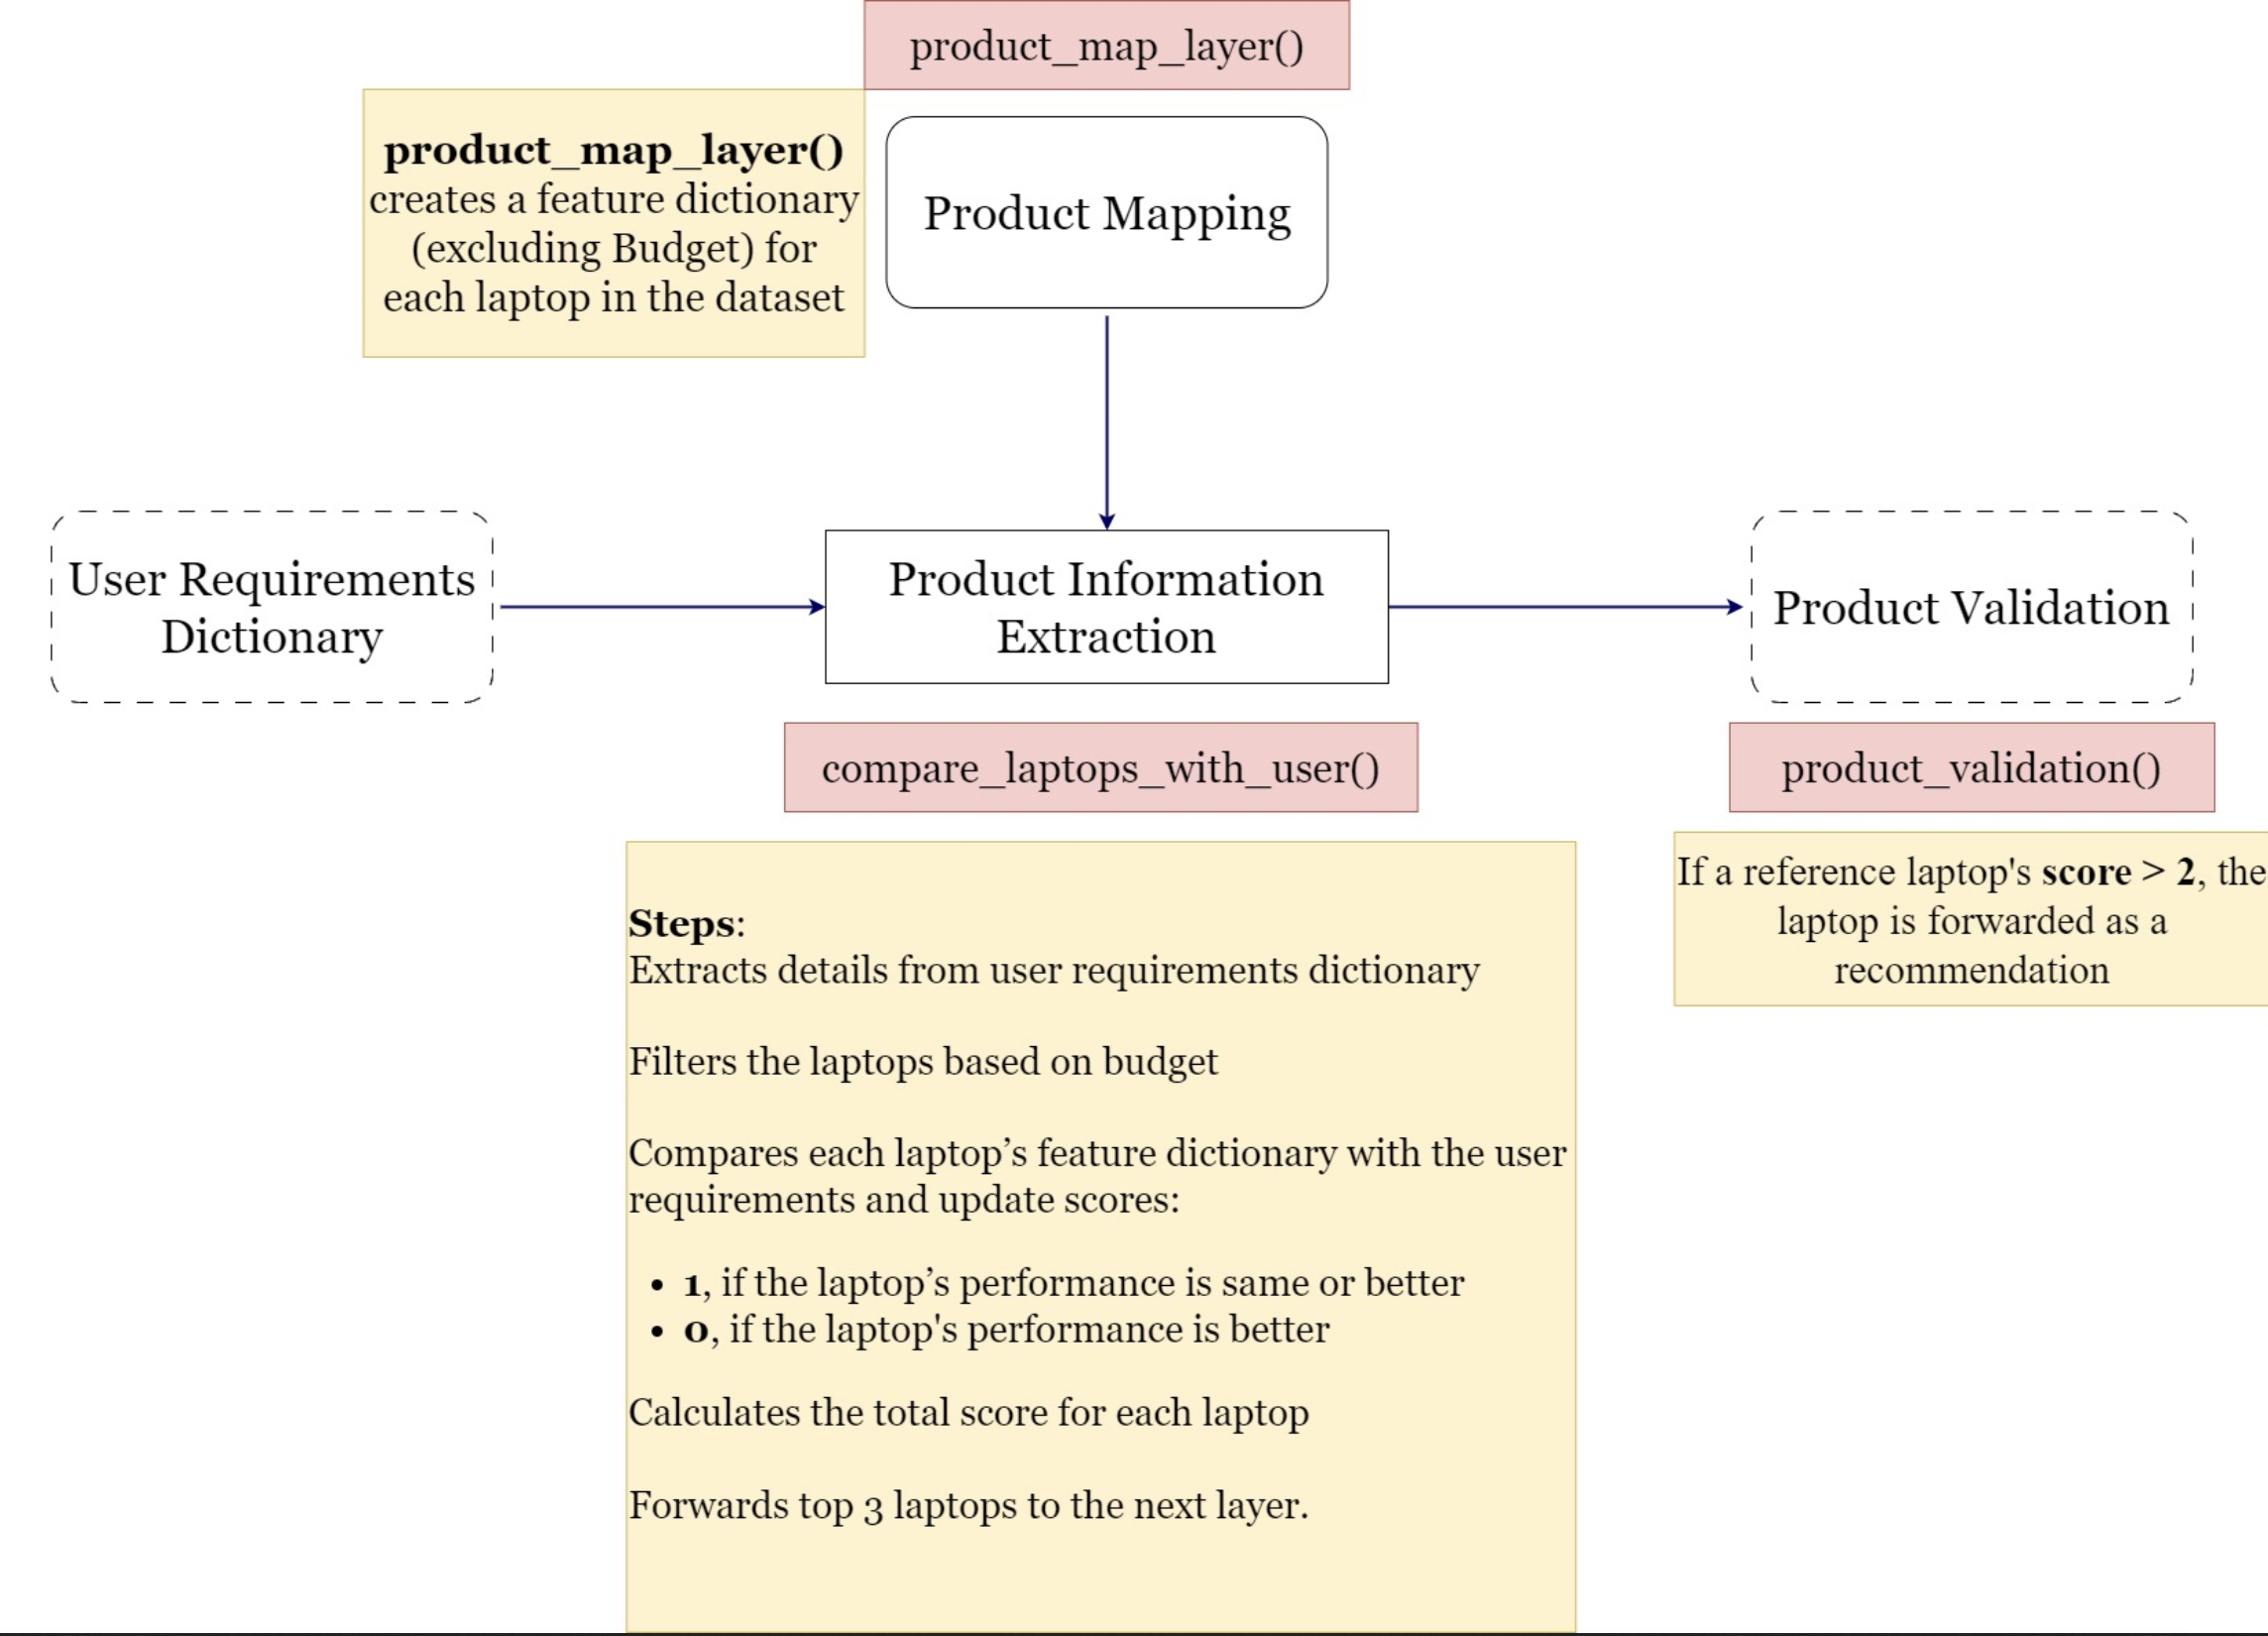

In [59]:
from IPython.display import Image
# Image(url="./stage2.png", width=1300, height=900)
image_path = '/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/stage2.png'
display(Image(filename=image_path, width=1300, height=900))

### 3.3 Implementing the Product Mapping and Information Extraction Layers

In this section, we take in the output of the previous layers, i.e. the user requirements, which is in the format of a Python dictionary.
<br>
Next we will extract the top 3 restaurant recommendations based on user's requirements.

This stage consists of the following helper functions that will implement the information extraction and product matching layers.

### `product_map_layer()`:

This function is responsible for extracting key features and criteria from restaurant descriptions. Here's a breakdown of how it works:

-  Use a prompt that assign it the role of a restaurant Specifications Classifier, whose objective is to extract key features and classify them based on restaurant descriptions.

- Provide step-by-step instructions for extracting restaurant features from description.

- Assign specific rules for each feature (e.g., 'Cuisine Variety': 'Cafeteria', 'Ambiance': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium' ) and associate them with the appropriate classification value (Low, Medium, or High).

- Includes Few Shot Prompting (sample conversation between the user and assistant) to demonstrate the expected result of the feature extraction and classification process.


In [60]:
def product_map_layer(laptop_description):
    delimiter = "#####"

    restaurant_info = {
        "Cuisine Variety": "(Type of the Cuisine. ex:- Mexican/Bar/Cafeteria/Fast_Food/Bar_Pub_Brewery/International/Pizzeria/Contemporary/American/Seafood/Burgers/Japanese/Chinese/Family/Italian/Breakfast-Brunch/Vietnamese/Bakery/Game/Cafe-Coffee_Shop/Regional)",
        "Area": "(Type of the Area. ex:- open/closed)",
        "Ambiance": "(Type of the Ambiance. ex:- familiar/quite)",
        "Rating": "(Type of the Rating is like low/medium/high)",
        "Alcohol Served": "(Answer is either of two  yes/no)",
        "Smoking Permitted": "(Answer as yes/no)",
        "Price Range": "(Price range in eithe of three low/medium/high)"
    }


    rating_values = {'low','medium','high'}
    ambiance_values = {'familiar', 'quite'}
    area_values = {'closed', 'open'}
    cuisine_values = {'Mexican', 'Bar', 'Cafeteria'}
    price_values = {'low','medium','high'}
    alcohol_values = {'no', 'yes'}
    smoking_values = {'no', 'yes'}

    prompt=f"""
    You are a Restaurant Search Classifier whose job is to extract the key features of Restaurant and classify them as per their requirements.
    To analyze each Restaurant, perform the following steps:

    Step 1: Extract the restaurant's primary Cuisine  from the this {cuisine_values}
    Step 2: Store the extracted features in {restaurant_info} \
    Step 3: Classify each of the items in {restaurant_info} into values based on the following rules: \

    The values for the key 'Cuisine_Variety' should only be from the allowed values: {cuisine_values}
    The values for the key 'Ambiance' should only be from the allowed values: {ambiance_values}
    The values for the key 'Area' should only be from the allowed values: {area_values}
    The values for the key 'Rating' should only be from the allowed values: {rating_values}
    The values for the key 'Alcohol Served' should only be from the allowed values:  {alcohol_values}
    The values for the key 'Smoking Permitted' should only be from the allowed values: {smoking_values}
    The values for the key 'Price_Range' should only be from the allowed values: {price_values}


    {delimiter}
    Cuisine Variety:
    - mex: <<< if Cuisine Variety value is Mexican>>> , \n
    - ame: <<< if Cuisine Variety value is Cafeteria >>> , \n
    - bar: <<< if Cuisine Variety value is Bar >>> , \n

    Ambiance:
    - familiar: <<< if Ambiance value is familiar >>> , \n
    - quite: <<< if Ambiance value is quite >>> , \n

    Area:
    - open: <<< if Area value is open >>> , \n
    - closed: <<< if Area value is closed >>> , \n

    Rating:
    - low: <<< if rating is low >>> , \n
    - medium: <<< if rating is medium >>> , \n
    - high: <<< if if rating is high >>> \n

    Smoking Permitted:
    - yes: <<< if Smoking Permitted is yes >>> , \n
    - no: <<< if Smoking Permitted is no >>> , \n


    Alcohol Served:
    - yes: <<< if Alcohol Served is yes >>> , \n
    - no: <<< if Alcohol Served is no >>> , \n


    {delimiter}

    {delimiter}
    Here is input output pair for few-shot learning:
    input 1: "The restaurant "La Virreina" offers a cozy dining experience with a closed ambiance, ensuring privacy and comfort. With a stellar rating of high, it promises exceptional quality. Guests can enjoy a medium-priced menu complemented by alcoholic beverages, while smoking is not permitted, maintaining a clean and healthy environment for all patrons."
    output 1: {{
                'Cuisine Variety': 'Cafeteria',
                'Area': 'closed',
                'Ambiance': "quite",
                'Rating': 'high',
                'Alcohol Served': 'yes',
                'Smoking Permitted': 'no',
                'Price Range': 'medium'
                }}

    {delimiter}
    ### Strictly don't keep any other text in the values of the JSON dictionary other than following:
    'Cuisine_Variety' : {cuisine_values}
    'Ambiance' : {ambiance_values}
    'Rating' : {rating_values}
    'Alcohol Served' :  {alcohol_values}
    'Smoking Permitted' : {smoking_values}
    'Price_Range' : {price_values}

    ###
    """
    input = f"""Follow the above instructions step-by-step and output the dictionary in JSON format {restaurant_info} for the following restaurant {restaurant_info}."""
    #see that we are using the Completion endpoint and not the Chatcompletion endpoint
    messages=[{"role": "system", "content":prompt },{"role": "user","content":input}]

    response = get_chat_completions(messages, json_format = True)

    return response

### Let's test this for one sample restaurant description by calling product_map_layer().

In [61]:
restaurant_description_1 = f"""
The restaurant "La Virreina" offers a nice dining experience with a closed ambiance, ensuring privacy and comfort. With a stellar rating of high, it promises exceptional quality. Guests can enjoy a medium-priced menu complemented by alcoholic beverages, while smoking is not permitted, maintaining a clean and healthy environment for all patrons.
"""

In [62]:
product_map_layer(restaurant_description_1)

{'Cuisine Variety': 'Cafeteria',
 'Area': 'closed',
 'Ambiance': 'quite',
 'Rating': 'high',
 'Alcohol Served': 'yes',
 'Smoking Permitted': 'no',
 'Price Range': 'medium'}

### Showing the result as a DataFrame

In [63]:
display(pd.DataFrame([product_map_layer(restaurant_description_1)]).T)

0
Cuisine Variety    Cafeteria
Area                  closed
Ambiance               quite
Rating                  high
Alcohol Served           yes
Smoking Permitted         no
Price Range           medium

In [64]:
# # Data type of the output response
print(type(product_map_layer(restaurant_description_1)))

<class 'dict'>


In [65]:
# # Check for consistency with iterate_response function
iterate_llm_response(product_map_layer, restaurant_description_1)

Iteration: 0
{'Cuisine Variety': 'Cafeteria', 'Area': 'closed', 'Ambiance': 'quite', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 1
{'Cuisine Variety': 'Cafeteria', 'Area': 'closed', 'Ambiance': 'quite', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 2
{'Cuisine Variety': 'Cafeteria', 'Area': 'closed', 'Ambiance': 'quite', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 3
{'Cuisine Variety': 'Cafeteria', 'Area': 'closed', 'Ambiance': 'quite', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium'}
--------------------------------------------------
Iteration: 4
{'Cuisine Variety': 'Cafeteria', 'Area': 'closed', 'Ambiance': 

### Run this code once to extract product info in the form of a dictionary

In [66]:

restaurant_df= pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/merged_df.csv', index_col=0)



In [67]:
restaurant_df.columns

Index(['Name', 'Address', 'Alcohol Served', 'Smoking Permitted', 'Price Range', 'Ambiance', 'Area',
       'Rating', 'Cuisine Variety', 'Operating Hours', 'Days', 'gps_link'],
      dtype='object')

In [68]:
# restaurant_df.drop(columns=['Unnamed: 0'], inplace=True)

In [69]:
restaurant_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 80 to 6160
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               100 non-null    object
 1   Address            100 non-null    object
 2   Alcohol Served     100 non-null    object
 3   Smoking Permitted  100 non-null    object
 4   Price Range        100 non-null    object
 5   Ambiance           100 non-null    object
 6   Area               100 non-null    object
 7   Rating             100 non-null    object
 8   Cuisine Variety    100 non-null    object
 9   Operating Hours    100 non-null    object
 10  Days               100 non-null    object
 11  gps_link           100 non-null    object
dtypes: object(12)
memory usage: 10.2+ KB


In [70]:
restaurant_df.columns

Index(['Name', 'Address', 'Alcohol Served', 'Smoking Permitted', 'Price Range', 'Ambiance', 'Area',
       'Rating', 'Cuisine Variety', 'Operating Hours', 'Days', 'gps_link'],
      dtype='object')

In [71]:
## Create a new column "restaurant_feature" that contains the dictionary of the restaurant features

restaurant_df['restaurant_feature'] = ('Name:' + restaurant_df['Name'].astype(str) + 'Address:' + restaurant_df['Address'].astype(str) + 'Alcohol Served:' + restaurant_df['Alcohol Served'].astype(str) + 'Smoking Permitted:' + restaurant_df['Smoking Permitted'].astype(str) + 'Price Range:' + restaurant_df['Price Range'].astype(str) +'Ambiance:' + restaurant_df['Ambiance'].astype(str) +'Area:' + restaurant_df['Area'].astype(str) +  'Rating:' + restaurant_df['Rating'].astype(str) + 'Cuisine Variety:' + restaurant_df['Cuisine Variety'].astype(str)).apply(lambda x: product_map_layer(x))


In [72]:
restaurant_df[['restaurant_feature', 'gps_link']]

restaurant_feature  \
80    {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
85    {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
163   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
172   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
201   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
243   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
303   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
310   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
335   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
367   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
442   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
496   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
609   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
623   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
788   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
865   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
912   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
972   {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1014  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1054  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1146  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1177  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1194  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1415  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1416  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1480  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1535  {'Cuisine Variety': 'Mexican', 'Area': 'closed...   
1782  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1840  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
1966  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2035  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2087  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2094  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2102  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2203  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2246  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2391  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2517  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2670  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2698  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2836  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2906  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
2921  {'Cuisine Variety': 'Mexican', 'Area': 'closed...   
2945  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3042  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3091  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3094  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3144  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3396  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3408  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3514  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3523  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3560  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3584  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3676  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3761  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3797  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
3821  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4057  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4170  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4289  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4295  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4347  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4349  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4460  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4504  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4618  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...   
4667  {'Cuisine Variety':

In [73]:
restaurant_df.columns

Index(['Name', 'Address', 'Alcohol Served', 'Smoking Permitted', 'Price Range', 'Ambiance', 'Area',
       'Rating', 'Cuisine Variety', 'Operating Hours', 'Days', 'gps_link', 'restaurant_feature'],
      dtype='object')

In [74]:
restaurant_df.to_csv("/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/updated_restaurant.csv",index=False,header = True)

In [75]:
restaurant_df.head(2)

Name                                            Address Alcohol Served  \
80  puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
85  puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   

   Smoking Permitted Price Range  Ambiance  Area  Rating Cuisine Variety Operating Hours  Days  \
80                no         low  familiar  open  medium         Mexican    09:00-12:00;  Sun;   
85                no         low  familiar  open     low         Mexican    09:00-12:00;  Sat;   

                                             gps_link  \
80  https://www.google.com/maps/search/?api=1&quer...   
85  https://www.google.com/maps/search/?api=1&quer...   

                                   restaurant_feature  
80  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...  
85  {'Cuisine Variety': 'Cafeteria', 'Area': 'clos...

In [76]:
restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 80 to 6160
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                100 non-null    object
 1   Address             100 non-null    object
 2   Alcohol Served      100 non-null    object
 3   Smoking Permitted   100 non-null    object
 4   Price Range         100 non-null    object
 5   Ambiance            100 non-null    object
 6   Area                100 non-null    object
 7   Rating              100 non-null    object
 8   Cuisine Variety     100 non-null    object
 9   Operating Hours     100 non-null    object
 10  Days                100 non-null    object
 11  gps_link            100 non-null    object
 12  restaurant_feature  100 non-null    object
dtypes: object(13)
memory usage: 15.0+ KB


### `compare_restaurants_with_user()`:

This function compares the user's profile with the different restaurants and come back with the top recommendations. It will perform the following steps:
    - It will take the user requirements dictionary as input
    - Filter the budget based on their price, keeping only the ones within the user's budget.
    - Calculate a score for each requirements based on how well it matches the user's requirements.
    - Sort the requirements based on their scores in descending order.
    - Return the top 3 requirements as a JSON-formatted string.

In [77]:
import pandas as pd  # Importing the pandas library for data manipulation
import json
def compare_restaurants_with_user(user_req_string):
    restaurant_df = pd.read_csv('/content/gdrive/MyDrive/Upgrad/GenAI/Restaurants Recommendation BOT/data/updated_restaurant.csv')

    # {
    #     'Cuisine Variety': 'Bar',
    #      'Ambiance': 'open',
    #     'Rating': 'high',
    #     'Alcohol Served': 'yes',
    #     'Smoking Permitted': 'yes',
    #     'Price Range': 'medium'
    # }

    user_requirements = response_dict_n

    # Extracting user requirements from the input string (assuming it's a dictionary)
    # Since the function parameter already seems to be a string, we'll use it directly instead of extracting from a dictionary

    # Extracting the budget value from user_requirements and converting it to an integer
    budget = user_requirements['Price Range']

    # budget
    # # Creating a copy of the DataFrame and filtering restaurants based on the budget
    filtered_restaurants = restaurant_df.copy()
    filtered_restaurants['Price Range'] = budget
    filtered_restaurants = filtered_restaurants[filtered_restaurants['Price Range'] <= budget].copy()
    # filtered_restaurants
    # # # Mapping string values 'low', 'medium', 'high' to numerical scores 0, 1, 2
    mappings = {'low': 0, 'medium': 1, 'high': 2}

    # # # Creating a new column 'Score' in the filtered DataFrame and initializing it to 0
    filtered_restaurants['Score'] = 0

    # # # Iterating over each restaurant in the filtered DataFrame to calculate scores based on user requirements
    for index, row in filtered_restaurants.iterrows():
        user_product_match_str = row['restaurant_feature']
        restaurant_values = user_product_match_str
        restaurant_values = dictionary_present(user_product_match_str)
        score = 0

    #     # Comparing user requirements with restaurant features and updating scores
        for key, user_value in user_requirements.items():
            # if key.lower() == 'budget':
            if key == 'Price Range':
                continue  # Skipping budget comparison
            restaurant_value = restaurant_values.get(key, None)
            # print(key, restaurant_value)
            restaurant_mapping = mappings.get(restaurant_value, -1)
            user_mapping = mappings.get(user_value, -1)
            if restaurant_mapping >= user_mapping:
                score += 1  # Incrementing score if restaurant value meets or exceeds user value

        filtered_restaurants.loc[index, 'Score'] = score  # Updating the 'Score' column in the DataFrame

    # Sorting restaurants by score in descending order and selecting the top 3 products
    top_restaurants = filtered_restaurants.drop('restaurant_feature', axis=1)
    top_restaurants = top_restaurants.sort_values('Score', ascending=False).head(3)
    top_restaurants_json = top_restaurants.to_json(orient='records')  # Converting the top restaurants DataFrame to JSON format

    # top_restaurants
    # print(top_restaurants_json)
    return top_restaurants_json

In [78]:
response_dict_n

{'Cuisine Variety': 'Cafeteria',
 'Ambiance': 'quite',
 'Area': 'open',
 'Rating': 'high',
 'Alcohol Served': 'yes',
 'Smoking Permitted': 'no',
 'Price Range': 'medium'}

In [79]:
type(response_dict_n)

dict

In [80]:
dictionary_present(response_dict_n)

{'Cuisine Variety': 'Cafeteria',
 'Ambiance': 'quite',
 'Area': 'open',
 'Rating': 'high',
 'Alcohol Served': 'yes',
 'Smoking Permitted': 'no',
 'Price Range': 'medium'}

In [81]:
top_3_restaurants = compare_restaurants_with_user(response_dict_n)



In [82]:
top_3_restaurants

'[{"Name":"puesto de tacos","Address":"esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico","Alcohol Served":"no","Smoking Permitted":"no","Price Range":"medium","Ambiance":"familiar","Area":"open","Rating":"medium","Cuisine Variety":"Mexican","Operating Hours":"09:00-12:00;","Days":"Sun;","gps_link":"https:\\/\\/www.google.com\\/maps\\/search\\/?api=1&query=22.1473922,-100.983092","Score":6},{"Name":"tacos los volcanes","Address":"avenida hivno nacional, san luis potosi, san luis potos, mexico","Alcohol Served":"no","Smoking Permitted":"no","Price Range":"medium","Ambiance":"quiet","Area":"closed","Rating":"high","Cuisine Variety":"American","Operating Hours":"10:00-23:30;","Days":"Sun;","gps_link":"https:\\/\\/www.google.com\\/maps\\/search\\/?api=1&query=22.1449787,-101.0056829","Score":6},{"Name":"Mariscos El Pescador","Address":"Himno Nacional 2104 Tangamanga, San Luis Potosi, SLP, Mexico","Alcohol Served":"no","Smoking Permitted":"no","Price Range":"medium","Ambiance":

In [83]:
# Get output in JSON Format
top_3_restaurants_json = json.loads(top_3_restaurants)
# type(top_3_laptops_json)
top_3_restaurants_json

[{'Name': 'puesto de tacos',
  'Address': 'esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'familiar',
  'Area': 'open',
  'Rating': 'medium',
  'Cuisine Variety': 'Mexican',
  'Operating Hours': '09:00-12:00;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1473922,-100.983092',
  'Score': 6},
 {'Name': 'tacos los volcanes',
  'Address': 'avenida hivno nacional, san luis potosi, san luis potos, mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'quiet',
  'Area': 'closed',
  'Rating': 'high',
  'Cuisine Variety': 'American',
  'Operating Hours': '10:00-23:30;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1449787,-101.0056829',
  'Score': 6},
 {'Name': 'Mariscos El Pescador',
  'Address': 'Himno Nacional 2104 Tangamanga, San Luis Potosi, SLP, Mex

In [84]:
# Get output in DataFrame Format

pd.DataFrame(json.loads(top_3_restaurants))

Name                                            Address Alcohol Served  \
0       puesto de tacos  esquina santos degollado y leon guzman, s.l.p....             no   
1    tacos los volcanes  avenida hivno nacional, san luis potosi, san l...             no   
2  Mariscos El Pescador  Himno Nacional 2104 Tangamanga, San Luis Potos...             no   

  Smoking Permitted Price Range  Ambiance    Area  Rating Cuisine Variety Operating Hours  \
0                no      medium  familiar    open  medium         Mexican    09:00-12:00;   
1                no      medium     quiet  closed    high        American    10:00-23:30;   
2                no      medium  familiar  closed  medium         Seafood    00:00-23:30;   

                   Days                                           gps_link  Score  
0                  Sun;  https://www.google.com/maps/search/?api=1&quer...      6  
1                  Sun;  https://www.google.com/maps/search/?api=1&quer...      6  
2  Mon;Tue;Wed;Thu;Fri;  https://www.google.com/maps/search/?api=1&quer...      6

In [85]:
pd.set_option('display.max_colwidth', 180)

display(pd.DataFrame([top_3_restaurants_json]).T)

0
0  {'Name': 'puesto de tacos', 'Address': 'esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico', 'Alcohol Served': 'no', 'Smoking Permitted': 'no', 'Price Range': 'medi...
1  {'Name': 'tacos los volcanes', 'Address': 'avenida hivno nacional, san luis potosi, san luis potos, mexico', 'Alcohol Served': 'no', 'Smoking Permitted': 'no', 'Price Range': '...
2  {'Name': 'Mariscos El Pescador', 'Address': 'Himno Nacional 2104 Tangamanga, San Luis Potosi, SLP, Mexico', 'Alcohol Served': 'no', 'Smoking Permitted': 'no', 'Price Range': 'm...

### `product_validation_layer()`:

This function verifies that the restaurants recommendations are good enough, has score greater than 2, and matches the user's requirements.

In [86]:
def recommendation_validation(restaurants_recommendation):
    # print(restaurants_recommendation)
    # data = json.loads(ast.literal_eval(restaurants_recommendation))
    # data = json.loads(ast.literal_eval(list(restaurants_recommendation)))
    data = list(restaurants_recommendation)
    data1 = []
    for i in range(len(list(restaurants_recommendation))):
        if int(list(restaurants_recommendation)[i]['Score']) > 2:
            data1.append(data[i])
    return data1

recommendation_validation(top_3_restaurants_json)

[{'Name': 'puesto de tacos',
  'Address': 'esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'familiar',
  'Area': 'open',
  'Rating': 'medium',
  'Cuisine Variety': 'Mexican',
  'Operating Hours': '09:00-12:00;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1473922,-100.983092',
  'Score': 6},
 {'Name': 'tacos los volcanes',
  'Address': 'avenida hivno nacional, san luis potosi, san luis potos, mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'quiet',
  'Area': 'closed',
  'Rating': 'high',
  'Cuisine Variety': 'American',
  'Operating Hours': '10:00-23:30;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1449787,-101.0056829',
  'Score': 6},
 {'Name': 'Mariscos El Pescador',
  'Address': 'Himno Nacional 2104 Tangamanga, San Luis Potosi, SLP, Mex

#### Now that you the top 3 restaurants extracted, let's pass it to the recommendation layer that'll send it to the user and the user can ask questions around it.

In [87]:
try:
    validated_data = recommendation_validation(top_3_restaurants_json)
    display(validated_data,'\n')
except:
    pass

[{'Name': 'puesto de tacos',
  'Address': 'esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'familiar',
  'Area': 'open',
  'Rating': 'medium',
  'Cuisine Variety': 'Mexican',
  'Operating Hours': '09:00-12:00;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1473922,-100.983092',
  'Score': 6},
 {'Name': 'tacos los volcanes',
  'Address': 'avenida hivno nacional, san luis potosi, san luis potos, mexico',
  'Alcohol Served': 'no',
  'Smoking Permitted': 'no',
  'Price Range': 'medium',
  'Ambiance': 'quiet',
  'Area': 'closed',
  'Rating': 'high',
  'Cuisine Variety': 'American',
  'Operating Hours': '10:00-23:30;',
  'Days': 'Sun;',
  'gps_link': 'https://www.google.com/maps/search/?api=1&query=22.1449787,-101.0056829',
  'Score': 6},
 {'Name': 'Mariscos El Pescador',
  'Address': 'Himno Nacional 2104 Tangamanga, San Luis Potosi, SLP, Mex

'\n'

In [88]:
import ast
import re

def extract_dictionary_from_string(string):
    regex_pattern = r"\{[^{}]+\}"

    dictionary_matches = re.findall(regex_pattern, str(string))

    # Extract the first dictionary match and convert it to lowercase
    if dictionary_matches:
        dictionary_string = dictionary_matches[0]
        dictionary_string = dictionary_string.lower()

        # Convert the dictionary string to a dictionary object using ast.literal_eval()
        dictionary = ast.literal_eval(dictionary_string)
    return dictionary

### 3.4: Product Recommendation Layer

Finally, we come to the product recommendation layer. It takes the output from the `compare_restaurants_with_user` function in the previous layer and provides the recommendations to the user. It has the following steps.
1. Initialize the conversation for recommendation.
2. Generate the recommendations and display in a presentable format.
3. Ask questions basis the recommendations.



In [89]:
def initialize_conv_reco(products):
    system_message = f"""
    You are an intelligent restaurant recomendation expert and you are tasked with the objective to \
    solve the user queries about any restaurant from the list in the user message \
    You should keep the user profile in mind while answering the questions.\

    Start with a brief summary of each restaurant in the following format, in decreasing order of price of restaurants:
    1. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as low>

    2. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as medium>

    3. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as high>

    """
    user_message = f""" These are the user's products: {products}"""
    conversation = [{"role": "system", "content": system_message },
                    {"role":"user","content":user_message}]
    # conversation_final = conversation[0]['content']
    return conversation

### Let's initialize the conversation for recommendation.

In [90]:
debug_conversation_reco = initialize_conv_reco(top_3_restaurants)
print(debug_conversation_reco[0]['content'])


    You are an intelligent restaurant recomendation expert and you are tasked with the objective to     solve the user queries about any restaurant from the list in the user message     You should keep the user profile in mind while answering the questions.
    Start with a brief summary of each restaurant in the following format, in decreasing order of price of restaurants:
    1. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as low>

    2. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as medium>

    3. <Restaurant Name> : <Major features of the Restaurant>, <Price Range as high>

    


In [91]:
pd.DataFrame([debug_conversation_reco[1]['content']]).T


0
0   These are the user's products: [{"Name":"puesto de tacos","Address":"esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico","Alcohol Served":"no","Smoking Permitted":...

In [92]:
result = extract_dictionary_from_string(debug_conversation_reco[1]['content'])

pd.DataFrame([result])

name                                                         address alcohol served  \
0  puesto de tacos  esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico             no   

  smoking permitted price range  ambiance  area  rating cuisine variety operating hours  days  \
0                no      medium  familiar  open  medium         mexican    09:00-12:00;  sun;   

                                                                      gps_link  score  
0  https:\/\/www.google.com\/maps\/search\/?api=1&query=22.1473922,-100.983092      6

### Let's see what the assistant responds with the new initialization.

In [93]:
debug_recommendation = get_chat_completions(debug_conversation_reco)
print(debug_recommendation + '\n')

Sure! Here is a summary of the restaurants based on the user's profile:

1. tacos los volcanes: Quiet ambiance, American cuisine, high rating. Price Range: medium
2. Mariscos El Pescador: Familiar ambiance, Seafood cuisine, medium rating. Price Range: medium

Do you want more information about any specific restaurant from the list?



#### Now, extract the dictionary out of the string

In [94]:

result = extract_dictionary_from_string(response_dict_n)

pd.DataFrame([result])

cuisine variety ambiance  area rating alcohol served smoking permitted price range
0       cafeteria    quite  open   high            yes                no      medium

In [95]:
debug_conversation_reco.append({"role": "user", "content": "This is my user profile" + str(response_dict_n)})
debug_conversation_reco.append({"role": "assistant", "content": debug_recommendation})


In [96]:
debug_user_input = "Which is ideal for family outing?"

In [97]:
debug_conversation_reco.append({"role": "user", "content": debug_user_input})
debug_response_asst_reco = get_chat_completions(debug_conversation_reco)
print('\n' + debug_response_asst_reco + '\n')


Based on your user profile and preference for a family outing, "Mariscos El Pescador" seems more suitable as it offers a familiar ambiance which is often more appropriate for a family outing.



## Combining all the 3 stages

In this layer, we combine all the three stages that we defined above.

`Stage 1` + `Stage 2` + `Stage 3`

### 3.5 Dialogue Management System

Bringing everything together, we create a `diagloue_mgmt_system()` function that contains the logic of how the different layers would interact with each other. This will be the function that we'll call to initiate the chatbot

In [98]:


def dialogue_mgmt_system():
    validated_reco = {}

    conversation = initialize_conversation()

    introduction = get_chat_completions(conversation)

    print(introduction + '\n')

    top_3_restaurants = None

    user_input = ''

    while(user_input != "exit"):

        # user_input = input("")
        # prompt = "<p style='color: blue; font-size: 26px;'>Enter your input:</p>"

        # # Display the prompt
        # display(HTML(prompt))

        # Take user input
        user_input = input()


        moderation = moderation_check(user_input)
        if moderation == 'Flagged':
            display("Sorry, this message has been flagged. Please restart your conversation.")
            break

        if top_3_restaurants is None:

            conversation.append({"role": "user", "content": user_input})

            response_assistant = get_chat_completions(conversation)
            moderation = moderation_check(response_assistant)
            if moderation == 'Flagged':
                display("Sorry, this message has been flagged. Please restart your conversation.")
                break


            confirmation = intent_confirmation_layer(response_assistant)

            print("Intent Confirmation Yes/No:",confirmation.get('result'))
            print(confirmation)

            if "No" in confirmation.get('result'):
                conversation.append({"role": "assistant", "content": str(response_assistant)})
                print("\n" + str(response_assistant) + "\n")

            else:
                print("\n" + str(response_assistant) + "\n")
                print('\n' + "Variables extracted!" + '\n')

                response = dictionary_present(response_assistant)
                # print(type(response_assistant))
                # print(response_assistant)


                print("Thank you for providing all the information. Kindly wait, while I fetch the products: \n\n")
                top_3_restaurants = compare_restaurants_with_user(response)

                print("\nTop 3 restaurants are : \n", top_3_restaurants)

                display(pd.DataFrame([top_3_restaurants]))


                # validated_reco = recommendation_validation(top_3_restaurants)

                try:
                    validated_data = recommendation_validation(top_3_restaurants)
                    display(validated_data,'\n')
                except:
                    pass

                conversation_reco = initialize_conv_reco(validated_reco)

                conversation_reco.append({"role": "user", "content": "\nThis is my user profile: \n" + str(response)})

                recommendation = get_chat_completions(conversation_reco)

                moderation = moderation_check(recommendation)
                if moderation == 'Flagged':
                    display("Sorry, this message has been flagged. Please restart your conversation.")
                    break

                conversation_reco.append({"role": "assistant", "content": str(recommendation)})

                print(str(recommendation) + '\n')
        else:
            conversation_reco.append({"role": "user", "content": user_input})

            response_asst_reco = get_chat_completions(conversation_reco)

            moderation = moderation_check(response_asst_reco)
            if moderation == 'Flagged':
                print("Sorry, this message has been flagged. Please restart your conversation.")
                break

            print('\n' + response_asst_reco + '\n')
            conversation.append({"role": "assistant", "content": response_asst_reco})

In [99]:
dialogue_mgmt_system()

Welcome to our Restaurant Recommendation Chatbot! I'm here to help you find the perfect restaurant based on your preferences. Please share your dining preferences with me so we can find the ideal restaurant for you. Let's get started!

Badari here
Intent Confirmation Yes/No: No
{'result': 'No', 'reason': 'Missing keys and values'}

Hello Badari! Welcome to our Restaurant Recommendation Chatbot. I'm here to assist you in finding the perfect restaurant based on your dining preferences. Please feel free to share your preferences regarding cuisine, ambiance, ratings, alcohol service, smoking areas, and your budget for dining out. Let's get started!

japanese
Intent Confirmation Yes/No: No
{'result': 'No', 'reason': 'Missing keys and values - Cuisine Variety, Ambiance, Area, Rating, Alcohol Served, Smoking Permitted, Price Range'}

Fantastic choice! Japanese cuisine offers a wide variety of delicious options. Do you prefer a casual dining experience or a more upscale setting for your restau

0
0  [{"Name":"puesto de tacos","Address":"esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico","Alcohol Served":"no","Smoking Permitted":"no","Price Range":"medium","Amb...

Here is a summary of the restaurants based on your preferences:

1. Sushi Delight : Authentic Japanese cuisine, quiet ambiance, medium price range

2. Ramen House : Cozy Japanese setting, medium price range

3. Sakura Garden : Japanese cuisine, peaceful outdoor dining area, medium price range

exit

If you have any more questions in the future, feel free to ask. Have a great day! Goodbye!



In [100]:
dialogue_mgmt_system()

Welcome to our Restaurant Recommendation Chatbot! I'm here to help you find the perfect restaurant based on your preferences. Please share your dining preferences and requirements with me.

Mexican 
Intent Confirmation Yes/No: No
{'result': 'No', 'reason': 'Missing keys and values - Cuisine Variety, Ambiance, Area, Rating, Alcohol Served, Smoking Permitted, Price Range'}

Welcome to our Restaurant Recommendation Chatbot! If you're craving Mexican cuisine, you're in for a treat! Could you please share more about your dining preferences so I can help you find the perfect restaurant?

open area
Intent Confirmation Yes/No: No
{'result': 'No', 'reason': 'Missing keys and values - Cuisine Variety, Area, Rating, Alcohol Served, Smoking Permitted, Price Range'}

Great choice! Open areas provide a wonderful dining experience. Do you have any specific preferences for ambiance?

quite ambiance
Intent Confirmation Yes/No: No
{'result': 'No', 'reason': 'Missing keys and values'}

A quiet ambiance c

0
0  [{"Name":"puesto de tacos","Address":"esquina santos degollado y leon guzman, s.l.p., s.l.p., mexico","Alcohol Served":"no","Smoking Permitted":"no","Price Range":"medium","Amb...

Based on your user profile, here is a list of restaurants that match your preferences:

1. Tacos & Tequila : Authentic Mexican cuisine, outdoor seating, quiet ambiance, affordable prices

Let me know if you would like more information about any specific restaurant or if you have any other preferences.

exit

Thank you for using the restaurant recommendation service. If you have any more questions in the future, feel free to ask. Have a great day! Goodbye!



## Part IV: Evaluation

In [101]:
def evaluate_model_response(tagged_dict, model_dict):
  score = 0
  mappings = {
      'low': 0,
      'medium': 1,
      'high': 2
  }

  for key in tagged_dict.keys():
    if key == 'price range':
      continue
    tagged_value = tagged_dict[key]
    model_value = model_dict[key]
    tagged_mapping = mappings.get(tagged_value, -1)
    model_mapping = mappings.get(model_value, -1)

    if model_mapping >= tagged_mapping:
        score += 1

  return score


In [102]:
foodie_conversation = [{"role":"assistant","content":"""Hi there! I'm an intelligent restaurant recommendation expert and I'm here to help you find the best restaurant  for your needs.
Please tell me a little bit about yourself and your requirements so that I can assist you better.
"""},
{"role":"user","content":"""Yes, I prefer restaurant with high rating"""},
{"role":"assistant","content":"Kindly let me know your price preference"},
{"role":"user","content":"""Yes, I prefer as price as low, """},
{"role":"assistant","content":"Kindly let me know your alcohol preference"},
{"role":"user","content":"""Yes, I prefer alcohol no, """},
{"role":"assistant","content":"Kindly let me know your smoking preference"},
{"role":"user","content":"""Yes, I prefer smoking no, """},
{"role":"assistant","content":"Kindly let me know your cuisine preference"},
{"role":"user","content":"""Yes, I prefer cuisine - Japanese"""},
{"role":"assistant","content":"Kindly let me know your ambiance preference"},
{"role":"user","content":"""Yes, I prefer ambiance: open"""},
{"role":"assistant","content":"""Thank you for letting me know.
Based on your preference for :
- price as low,
- alcohol no,
- smoking  no,
- cuisine as Mexican,
- ambiance as open,
I would recommend a restaurant  with a high rating.
This will ensure that you can enjoy your dining with excellent dinner quality.
Now, I have a question to better understand your needs.
Are you primarily looking for a restaurant that you can easily drive around?"""
},
{"role":"user","content":"I prefer using my restaurant at a nearby location"},
{"role":"assistant","content":"""
Thank you for providing that information.
Since you primarily purpose of restaurant visit in a nearby location, low price may not be a top priority for you.
Now, I have one more question to help me understand your requirements better.
Could you kindly let me know your price for the restaurant ?
This will help me find options that fit within your price range while meeting the specified requirements."""},
{"role":"user","content":"high"}
]

foodie_conversation_initialize = initialize_conversation()
foodie_conversation_initialize.extend(foodie_conversation)
foodie_conversation_assistant_output = get_chat_completions(foodie_conversation_initialize)
foodie_response_dict = dictionary_present(foodie_conversation_assistant_output)
foodie_dict = extract_dictionary_from_string(foodie_response_dict)
print(foodie_dict)

{'cuisine variety': 'japanese', 'ambiance': 'open', 'area': 'nearby', 'rating': 'high', 'alcohol served': 'no', 'smoking permitted': 'no', 'price range': 'high'}


### Dictionary for a foodie person

In [103]:
foodie_tagged_dict = {
    'cuisine variety': 'Japanese',
    'ambiance': 'closed',
    'rating': 'low',
    'alcohol served': 'yes',
    'smoking permitted': 'yes',
    'price range': 'low'
}
print(foodie_tagged_dict)

{'cuisine variety': 'Japanese', 'ambiance': 'closed', 'rating': 'low', 'alcohol served': 'yes', 'smoking permitted': 'yes', 'price range': 'low'}


### Dictionary for a student group

In [104]:
student_conversation = [{"role":"assistant","content":"Hi there! I'm an intelligent restaurant recommendation expert and I'm here to help you find the best restaurant for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
{"role":"user","content":"i am a foodie and i'm looking for a restaurant"},
{"role":"assistant","content":"Great! As a foodie, you likely have specific requirements for a restaurant that will support your foodie needs. Could you please provide me with more information about your requirements? Are you looking for a restaurant for general purpose, such as dining, smoking, alcohol, high rating, low price Or do you have any need the restaurant to handle? Understanding your needs will help me recommend the best restaurant for you."},
{"role":"user","content":"I am working as a food researcher and I do work with restaurants as a professional cook and tradesperson who is proficient in all aspects of food preparation, often focusing on a particular cuisine."},
{"role":"assistant","content":"Thank you for providing that information. As an food researcher, you require a restaurant that can handle foodies need like dining, party, alcohol, smoking, high rating, smoking. May I know if you plan to visit with large group or a small group like family? Understanding the nature of your need will help me determine the features, facilities and capabilities of a restaurant."},
{"role":"user","content":"Yes, occasionally. I'm currently looking to go for a birthday party"},
{"role":"assistant","content":"Thank you for sharing that. Planning a birthday party can be resource-intensive, especially when dealing with a lot of kids. It requires a restaurant with efficent and trained staff. Do you also want to arrange for a return gifts? Additionally, do you also want to arrange for drop to different locations?"},
{"role":"user","content":"I need a decent party and to put an impact on college and office staff"},
{"role":"assistant","content":"Understood. Based on your requirements as an food researcher working as professional cook with different restaurants, I would recommend the following specifications for your restaurant: - (Cuisine Variety': 'Mexican', 'Ambiance': 'open', 'Rating': 'high', 'Alcohol Served': 'yes', 'Smoking Permitted': 'no', 'Price Range': 'medium')  Now, I need to know your budget for the restaurant. Could you please let me know your maximum budget option?"},
{"role":"user","content":"approximately low/medium"}
]

student_conversation_initialize = initialize_conversation()
student_conversation_initialize.extend(student_conversation)
student_conversation_assistant_output = get_chat_completions(student_conversation_initialize)
student_response_dict = dictionary_present(student_conversation_assistant_output)
student_dict = extract_dictionary_from_string(student_response_dict)
print(student_dict)

{'cuisine variety': 'mexican', 'area': 'open', 'ambiance': 'lively', 'rating': 'high', 'alcohol served': 'yes', 'smoking permitted': 'no', 'price range': 'medium'}


In [105]:
student_tagged_dict = {'cuisine variety': 'Japanese','area': 'open', 'ambiance': 'quite', 'rating': 'high', 'alcohol served': 'no', 'smoking permitted': 'no', 'price range': 'low'}
print(student_tagged_dict)

{'cuisine variety': 'Japanese', 'area': 'open', 'ambiance': 'quite', 'rating': 'high', 'alcohol served': 'no', 'smoking permitted': 'no', 'price range': 'low'}


### Dictionary for a business man

In [106]:
business_conversation = [
{"role":"assistant","content":"Hi there! I'm an intelligent restaurant researcher and I'm here to help you find the best restaurant researcher for your needs. Please tell me a little bit about yourself and your requirements so that I can assist you better."},
{"role":"user","content":"Hi. I a a business executive. I'm here to find a restaurant that fits my needs"},
{"role":"assistant","content":"Great! As a business executive, having a reliable and efficient restaurant researcher is crucial for your work. May I know what kind of tasks you primarily focus on? Are you involved in tasks such as Cuisine Variety, Ambiance, Rating, Alcohol Served, Smoking Permitted, Price Range? Understanding your specific food requirements will help me recommend the best restaurant researcher for you. "},
{"role":"user","content":"I'll use my restaurant researcher for day-to-day work such as taking clients, customer to the restaurant"},
{"role":"user","content":"""Yes, I prefer restaurant with high rating"""},
{"role":"assistant","content":"Kindly let me know your price preference"},
{"role":"user","content":"""Yes, I prefer as price as high, """},
{"role":"assistant","content":"Kindly let me know your alcohol preference"},
{"role":"user","content":"""Yes, I prefer alcohol yes, """},
{"role":"assistant","content":"Kindly let me know your smoking preference"},
{"role":"user","content":"""Yes, I prefer smoking yes, """},
{"role":"assistant","content":"Kindly let me know your cuisine preference"},
{"role":"user","content":"""Yes, I prefer cuisine - Bar,"""},
{"role":"assistant","content":"Kindly let me know your ambiance preference"},
{"role":"user","content":"""Yes, I prefer ambiance: closed"""},
{"role":"assistant","content":"Thank you for providing that information. Based on your restaurant requirements, it seems like you need a restaurant researcher that can handle multiple purposes, has good closed space, and a decent size. Drinking and smoking will also be prefered. Do you have any specific preferences or requirements?"},
{"role":"user","content":"""
I require a highly accomodative restaurant that can offer multiple Cuisine parallely based on user need.
Drinking is not a priority, but good to have"""},
{"role":"assistant","content":"Understood. In that case, a business conversations with high team size and multiple Cuisine parallely capabilities would be ideal for you. Since drrinking is a priority, we can focus more on offering multiple Cuisine parallely. Do you have any specific price range in mind for your restaurant researcher? Knowing your price range will help me find options that fit within your price range while meeting your specified requirements."},
{"role":"user","content":"No price range is not a constraint. choose the best"},
{"role":"assistant","content":"""Thank you for letting me know. In that case, I will recommend a business conversation with seating arragements, good quality. This will ensure that you can have an awsome dining experiance. Here are the specifications for the business conversation I recommend for you:
- Cuisine Variety': 'Bar'
- 'Ambiance': 'familiar'
- 'Area': 'closed'
- 'Rating': 'high'
- 'Alcohol Served': 'yes'
- 'Smoking Permitted': 'yes',
- 'Price Range': Not specified Please note that the budget is not specified as you mentioned that it is not a constraint. However, if you have any specific budget in mind, please let me know and I can provide you with more tailored recommendations."""},
{"role":"user","content":"okay. should be high"}
]
business_conversation_initialize = initialize_conversation()
business_conversation_initialize.extend(business_conversation)
business_conversation_assistant_output = get_chat_completions(business_conversation_initialize)
business_response_dict = dictionary_present(business_conversation_assistant_output)
business_dict = extract_dictionary_from_string(business_response_dict)
print(business_dict)

{'cuisine variety': 'bar', 'area': 'closed', 'ambiance': 'familiar', 'rating': 'high', 'alcohol served': 'yes', 'smoking permitted': 'yes', 'price range': 'high'}


In [107]:
business_tagged_dict = {'cuisine variety': 'Japanese', 'ambiance': 'quite', 'rating': 'high', 'alcohol served': 'yes', 'smoking permitted': 'no', 'price range': 'medium'}
print(business_tagged_dict)

{'cuisine variety': 'Japanese', 'ambiance': 'quite', 'rating': 'high', 'alcohol served': 'yes', 'smoking permitted': 'no', 'price range': 'medium'}


## Evealuation execution

In [108]:
foodie_score = evaluate_model_response(business_tagged_dict,business_dict)
print(foodie_score)

student_score = evaluate_model_response(student_tagged_dict, student_dict )
print(student_score)

business_score = evaluate_model_response(business_tagged_dict,business_dict)
print(business_score)

5
6
5


### You can see that student score is highest where as foodie and businessmen score is less.
The model gave lesser score as the number of keys didnt match

## Part V: Areas of Improvement and Final Comments¶

### Future Scope of Work

The output format of each layer is inconsistent. To address this, the function API capability of GPT can be utilized to ensure the output format aligns with the input request. Once products are extracted, the dialogue flow does not support recalling product extraction if there is a change in intent. Implementing an additional layer to detect changes in user intent and using this flag to recall product extraction based on the updated intent would be beneficial. Additionally, incorporating a user satisfaction rating could enhance the system.

